In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2,3"

%load_ext autoreload
%autoreload 2

In [2]:
import torch
from pytorch_lightning import seed_everything
device = 'cuda'if torch.cuda.is_available() else 'cpu'


import time
import numpy as np
import matplotlib.pyplot as plt

In [4]:
cd ..


/homes/yl006/projects/dvae-lib


In [5]:
from omegaconf import OmegaConf
import hydra
from hydra.core.hydra_config import HydraConfig
import pytorch_lightning as pl
import pandas as pd
from src.metric import ModelEvaluator
from pathlib import Path

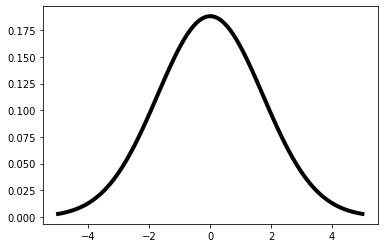

In [5]:
def gaussian(x): 
    return (1 / (3* np.sqrt(np.pi))) * np.exp(-0.5 * (x**2 / 3))
x = np.linspace(-5, 5, 100)
plt.plot(x, gaussian(x), c='k', lw=4)

In [6]:
ckpts_path = sorted(list(Path('multirun/').rglob('*.ckpt')))

In [7]:
# 4 (base, freeze, prg, prgCycle) * 2 (dsa,dsaFull) * 3 dims * 2 datasets
len(ckpts_path)

57

In [8]:
# ckpts_path = [i for i in ckpts_path if '2022-01-02/01-52-08' in str(i)]  # multiple
# ckpts_path = [i for i in ckpts_path if '2022-01-02/00-39-19' in str(i)]  # 2d
# ckpts_path = [i for i in ckpts_path if '2022-01-06/02-16-41' in str(i)] # factor-rich
# ckpts_path = [i for i in ckpts_path if '2022-01-06/03-07-40' in str(i)] # multiple
ckpts_path = [i for i in ckpts_path if '2022-01-10' in str(i)] # factor-rich base

In [12]:
len(ckpts_path)

2

In [10]:
row_name = list(range(len(ckpts_path)))

In [11]:
!module load cuda/11.2-cudnn8.1.0

In [12]:
import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)
    
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

2022-01-10 13:50:42.527154: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-10 13:50:44.114051: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9658 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:81:00.0, compute capability: 7.5
2022-01-10 13:50:44.116968: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9658 MB memory:  -> device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:82:00.0, compute capability: 7.5


In [24]:
column_name = [
    'ckpt', 'run', 'epoch', 'model', 'prg', 'data', 'data_path', 'z_dim', 'arch', 'likelihood', 'switch_epoch',
    'pre_swap_acc', 'post_g_acc', 'post_l_acc',
    'pre_swap_rpa', 'post_g_rpa', 'post_l_rpa',
    'pre_swap_rca', 'post_g_rca', 'post_l_rca',
    'recon_fad'
]

In [9]:
param = list(Path(ckpts_path[0].parents[4]).rglob('hparams.yaml'))[0]

In [10]:
cfg = OmegaConf.load(param)

In [11]:
from src.models.modules.audio_synth import GflFromMel

In [12]:
GflFromMel(cfg)

NameError: name 'NMEL' is not defined

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/import/linux/python/3.8.2/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/import/linux/python/3.8.2/lib/python3.8/threading.py", line 1254, in run
    self.function(*self.args, **self.kwargs)
  File "/homes/yl006/projects/dvae-lib/.venv/lib/python3.8/site-packages/music21/ipython21/__init__.py", line 35, in loadNoMagic
    load_ipython_extension(localIP)
  File "/homes/yl006/projects/dvae-lib/.venv/lib/python3.8/site-packages/music21/ipython21/ipExtension.py", line 21, in load_ipython_extension
    ip.run_line_magic('config', "InlineBackend.figure_format = 'retina'")
  File "/homes/yl006/projects/dvae-lib/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2348, in run_line_magic
    result = fn(*args, **kwargs)
  File "/homes/yl006/projects/dvae-lib/.venv/lib/python3.8/site-packages/decorator.py", line 232, in fun
    return caller(func, *(extras + args), 

In [23]:
data = []
loaded_data = None
eval_local = True

total_time = 0
    
for ckpt in ckpts_path:
    param = list(Path(ckpt.parents[4]).rglob('hparams.yaml'))
    assert len(param) == 1
    param = param[0]

    cfg = OmegaConf.load(param)
    seed_everything(cfg.train.random_seed)
    model: pl.LightningModule = hydra.utils.instantiate(
        cfg.model,
        _recursive_=False,
    )
    model = model.load_from_checkpoint(ckpt, strict=False)
    model.to(device)
    model.eval()
    
    if loaded_data != cfg.data.datasets.train._target_.split('.')[-1]:
        data_config = cfg.data
        datamodule: pl.LightningDataModule = hydra.utils.instantiate(cfg.data, _recursive_=False)
        datamodule.setup()
        loaded_data = cfg.data.datasets.train._target_.split('.')[-1]

    
    start = time.time()
    global_score, local_score, fad = ModelEvaluator(
        model, datamodule, device, n_sample=60, file_dir=ckpt.parents[3] / 'eval_files', evaluate_local=eval_local
    )()
    total_time += time.time() - start
    row = []
    row.append(str(ckpt))  # ckpt path
    row.append(str(ckpt.parents[1]).split('/')[-1])  # run name
    row.append(ckpt.name.split('=')[1].split('-')[0])  # epoch
    row.append(cfg['model']['_target_'])  # model
    if cfg['model']['_target_'].split('.')[-1] == 'SimpleDVAE':
        prg = cfg['model']['progressive']
    elif cfg['model']['_target_'].split('.')[-1] in ['PrgDVAE', 'PrgCycleDVAE']:
        prg = True
    else:
        raise ValueError
    row.append(prg)  # progressive
    row.append(cfg['data']['datasets']['train']['_target_'].split('.')[-1])  # dataset
    row.append('/'.join(cfg['data']['datasets']['train']['path_to_data'].split('/')[:-1])) # dataset path
    row.append(cfg['model']['z_dim'])
    if cfg['model']['prior'] == '2' and \
        cfg['model']['feature'] == '=' and \
        cfg['model']['content_condition']:
        arch = 'DSA_Full'
    elif cfg['model']['prior'] == '2' and \
        cfg['model']['feature'] == '0' and \
        not cfg['model']['content_condition']:
        arch = 'DSA'
    elif cfg['model']['prior'] == '0' and \
        cfg['model']['feature'] == '0' and \
        not cfg['model']['content_condition']:
        arch = 'Static'
    else:
        raise NotImplementedError
    row.append(arch)
    row.append(cfg['model']['likelihood'])
    row.append(cfg['model']['switch_epoch'])
    row.append(global_score['lda-pre_swap'])
    row.append(global_score['lda-post_g_swap'])
    row.append(global_score['lda-post_l_swap'])
    if eval_local:
        row.append(local_score['pre_swap_rpa'])
        row.append(local_score['post_g_swap_rpa'])
        row.append(local_score['post_l_swap_rpa'])
        row.append(local_score['pre_swap_rca'])
        row.append(local_score['post_g_swap_rca'])   
        row.append(local_score['post_l_swap_rca'])
        row.append(fad['recon_fad'])
    data.append(row)
df = pd.DataFrame(data, index=row_name, columns=column_name)

Global seed set to 42


Allocating samples from /import/c4dm-datasets/URMP/synth-dataset/4s-dataset/vn/train/audio ...
Found 1545 <vn> samples!
Allocating samples from /import/c4dm-datasets/URMP/synth-dataset/4s-dataset/tpt/train/audio ...
Found 534 <tpt> samples!
Allocating samples from /import/c4dm-datasets/URMP/synth-dataset/4s-dataset/vn/val/audio ...
Found 193 <vn> samples!
Allocating samples from /import/c4dm-datasets/URMP/synth-dataset/4s-dataset/tpt/val/audio ...
Found 67 <tpt> samples!
size of the dataset:  2079


KeyboardInterrupt: 

In [15]:
df

ckpt       run epoch  \
0  multirun/2022-01-10/09-33-27/0/wandb/run-20220...  1nr6pmzp  3994   
1  multirun/2022-01-10/09-33-27/1/wandb/run-20220...  on9os0i1  3804   

                        model    prg       data  \
0  src.models.dvae.SimpleDVAE  False  DMelodies   
1  src.models.dvae.SimpleDVAE  False       Urmp   

                                           data_path  z_dim arch likelihood  \
0  data/dmelodies_dataset/wav_datasets/C_4_major-...     16  DSA          =   
1  /import/c4dm-datasets/URMP/synth-dataset/4s-da...     16  DSA          =   

   ...  pre_swap_acc  post_g_acc  post_l_acc  pre_swap_rpa  post_g_rpa  \
0  ...      0.508332    0.491665    0.470000      0.937926    0.938349   
1  ...      0.671579    0.177651    0.357462      0.854199    0.851653   

   post_l_rpa  pre_swap_rca  post_g_rca  post_l_rca  recon_fad  
0    0.935887      0.938644    0.939047    0.936551   0.505161  
1    0.865154      0.857092    0.854554    0.867151   3.713374  

[2 rows x 21 columns]

In [16]:
df.to_csv('results/factor_rich.csv')
df.to_pickle('results/factor_rich.pkl')

In [18]:
pd.read_csv('results/factor_rich.csv')

Unnamed: 0                                               ckpt       run  \
0           0  multirun/2022-01-06/02-16-41/0/wandb/run-20220...  34o1ona0   
1           1  multirun/2022-01-06/02-16-41/1/wandb/run-20220...  1ifx0em0   

   epoch                                  model   prg       data  \
0   3893  src.models.prgCycle_dvae.PrgCycleDVAE  True  DMelodies   
1   3998  src.models.prgCycle_dvae.PrgCycleDVAE  True       Urmp   

                                           data_path  z_dim arch  ...  \
0  data/dmelodies_dataset/wav_datasets/C_4_major-...     16  DSA  ...   
1  /import/c4dm-datasets/URMP/synth-dataset/4s-da...     16  DSA  ...   

   pre_swap_acc  post_g_acc  post_l_acc  pre_swap_rpa  post_g_rpa  post_l_rpa  \
0           1.0         1.0         1.0      0.936544    0.847923    0.834611   
1           1.0         1.0         1.0      0.851815    0.832671    0.748896   

   pre_swap_rca  post_g_rca  post_l_rca  recon_fad  
0      0.937238    0.850751    0.837427   0.593554  
1      0.855021    0.841768    0.755443   5.224781  

[2 rows x 21 columns]

In [24]:
def is_freeze(ckpt):
    param = list(Path(ckpt.parents[4]).rglob('hparams.yaml'))
    assert len(param) == 1
    param = param[0]
    cfg = OmegaConf.load(param)
    if cfg['model']['freeze_global_on_switch']:
        return True
    else:
        return False
    
def determine_method(row):
    param = list(Path(row['ckpt']).parents[4].rglob('hparams.yaml'))
    assert len(param) == 1
    param = param[0]
    cfg = OmegaConf.load(param)
    if row['model'].split('.')[-1] == 'SimpleDVAE':
        if cfg['model']['freeze_global_on_switch']:
            return 'freeze'
        else:
            return 'base'
    elif row['model'].split('.')[-1] == 'PrgCycleDVAE':
        return 'prgCycle'
    elif row['model'].split('.')[-1] == 'PrgDVAE':
        return 'prg'
    

In [25]:
def map_arch_to_shape(x):
    if x.arch == 'DSA':
        return '^'
    elif x.arch == 'DSA_Full':
        return 'o'
    else:
        raise ValueError
    
def map_method_to_color(x):
    if x.freeze == 'prgCycle':
        return 'r'
    elif x.freeze == 'prg':
        return 'orange'
    elif x.freeze == 'freeze':
        return 'cyan'
    elif x.freeze == 'base':
        return 'k'
    else:
        raise ValueError

In [84]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.patheffects as pe


def draw_global_acc(dataset, alpha=0.5, legend=True, save_path=None):
    df = pd.read_csv('results/final.csv')
    legend_elements = [
        Patch(color='k', label='DSAE', alpha=alpha),
        Patch(color='cyan', label='DSAE-f', alpha=alpha),
        Patch(color='orange', label='TS-DSAE w/o regs', alpha=alpha),
        Patch(color='red', label='TS-DSAE', alpha=alpha),
        Line2D([0], [0], marker='^', color='w', label='factorised q', markerfacecolor='w', markersize=10, markeredgecolor='k'),
        Line2D([0], [0], marker='o', color='w', label='full q', markerfacecolor='w', markersize=10, markeredgecolor='k')
    ]
    
    assert dataset in ['DMelodies', 'Urmp']
    fig, ax = plt.subplots(2, 3, figsize=(3*2, 2*2), sharex=True, sharey=True)
    for row in range(2):
        for col, d in enumerate([8, 16, 32]):
            dd = df[(df.z_dim == d) & (df.data == dataset)]
            arch = dd.arch.to_numpy()  # determine shape
            method = dd.freeze.to_numpy()  # determine color
            shapes = dd.apply(lambda x: map_arch_to_shape(x), axis=1).to_numpy()
            colors = dd.apply(lambda x: map_method_to_color(x), axis=1).to_numpy()

            y = dd.pre_swap_acc.to_numpy()
            if row == 0:
                x = dd.post_g_acc.to_numpy()
            else:
                x = dd.post_l_acc.to_numpy()
            for i, j, k, l, a, m in zip(x, y, shapes, colors, arch, method):
                label = '-'.join([a, m])
                ax[row][col].scatter(i, j, marker=k, c=l, alpha=alpha, edgecolor='black', s=100)
    #             ax[row][col].set_xlim((0,1))
    #             ax[row][col].set_ylim((0.7,1))
                ax[row][col].grid(True)
            if row == 0 and col ==1:
                ax[row][col].set_xlabel('F1 post-global swap', fontsize=12)
            if row == 1 and col ==1:
                ax[row][col].set_xlabel('F1 post-local swap', fontsize=12)
            if legend:
                if row == 0 and col == 1:
                    ax[row][col].legend(
                        handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=[0.5, 1.45],
                        fancybox=True, fontsize='medium', edgecolor='k'
                    )
             
    plt.subplots_adjust(wspace=0.085, hspace=0.25)
    fig.text(0.04, 0.5, 'F1 pre-swap', va='center', rotation='vertical', fontsize=12) 
    if save_path is not None:
        fname = '-'.join(['eval', dataset, 'global'])
        fname +='.png'
        plt.savefig(Path(save_path) / fname, bbox_inches = "tight", dpi=300)

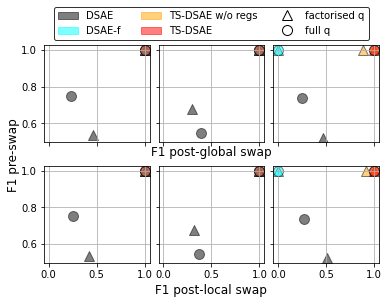

In [347]:
draw_global_acc('DMelodies', save_path='results/')

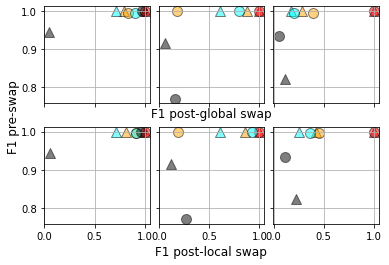

In [348]:
draw_global_acc('Urmp', legend=False, save_path='results/')

In [87]:
def draw_local_acc(dataset, alpha=0.5, legend=True, save_path=None):
    df = pd.read_csv('results/final.csv')
    df['freeze'] = df_main.apply(lambda row: determine_method(row), axis=1)
    legend_elements = [
        Patch(color='k', label='DSAE', alpha=alpha),
        Patch(color='cyan', label='DSAE-f', alpha=alpha),
        Patch(color='orange', label='TS-DSAE w/o regs', alpha=alpha),
        Patch(color='red', label='TS-DSAE', alpha=alpha),
        Line2D([0], [0], marker='^', color='w', label='factorised q', markerfacecolor='w', markersize=10, markeredgecolor='k'),
        Line2D([0], [0], marker='o', color='w', label='full q', markerfacecolor='w', markersize=10, markeredgecolor='k')
    ]
    
    assert dataset in ['DMelodies', 'Urmp']
    fig, ax = plt.subplots(2, 3, figsize=(3*2, 2*2), sharex=True, sharey=True)
    for row in range(2):
        for col, d in enumerate([8, 16, 32]):
            dd = df[(df.z_dim == d) & (df.data == dataset)]
            arch = dd.arch.to_numpy()  # determine shape
            method = dd.freeze.to_numpy()  # determine color
            shapes = dd.apply(lambda x: map_arch_to_shape(x), axis=1).to_numpy()
            colors = dd.apply(lambda x: map_method_to_color(x), axis=1).to_numpy()

            y = dd.pre_swap_rpa.to_numpy()
            if row == 0:
                x = dd.post_g_rpa.to_numpy()
            else:
                x = dd.post_l_rpa.to_numpy()
            for i, j, k, l, a, m in zip(x, y, shapes, colors, arch, method):
                label = '-'.join([a, m])
                ax[row][col].scatter(i, j, marker=k, c=l, alpha=alpha, edgecolor='black', s=100)
    #             ax[row][col].set_xlim((0,1))
    #             ax[row][col].set_ylim((0.7,1))
                ax[row][col].grid(True)
            if row == 0 and col ==1:
                ax[row][col].set_xlabel('RPA post-global swap', fontsize=12)
            if row == 1 and col ==1:
                ax[row][col].set_xlabel('RPA post-local swap', fontsize=12)
            if legend:
                if row == 0 and col == 1:
                    ax[row][col].legend(
                        handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=[0.5, 1.45],
                        fancybox=True, fontsize='medium', edgecolor='k'
                    )
             
    plt.subplots_adjust(wspace=0.085, hspace=0.25)
    fig.text(0.01, 0.5, 'RPA pre-swap', va='center', rotation='vertical', fontsize=12) 
    if save_path is not None:
        fname = '-'.join(['eval', dataset, 'local'])
        fname +='.png'
        plt.savefig(Path(save_path) / fname, bbox_inches = "tight", dpi=300)

In [26]:
df = pd.read_csv('results/final.csv')
df['freeze'] = df.apply(lambda row: determine_method(row), axis=1)

In [31]:
df[(df['freeze'] == 'prgCycle') & (df['arch'] == 'DSA') & (df['z_dim'] == 16)]

Unnamed: 0                                               ckpt       run  \
1            1  multirun/2021-12-25/21-46-06/1/wandb/run-20211...  3qqrafr3   
28          28  multirun/2021-12-28/17-14-43/1/wandb/run-20211...  100rp4l2   

    epoch                                  model   prg       data  z_dim arch  \
1    3910  src.models.prgCycle_dvae.PrgCycleDVAE  True       Urmp     16  DSA   
28   3968  src.models.prgCycle_dvae.PrgCycleDVAE  True  DMelodies     16  DSA   

    pre_swap_acc  post_g_acc  post_l_acc  pre_swap_rpa  post_g_rpa  \
1            1.0         1.0         1.0      0.847221    0.827553   
28           1.0         1.0         1.0      0.933993    0.901385   

    post_l_rpa  pre_swap_rca  post_g_rca  post_l_rca  recon_fad    freeze  
1     0.730547      0.852654    0.836416    0.737081   7.150756  prgCycle  
28    0.894276      0.934682    0.902466    0.895355   1.495380  prgCycle

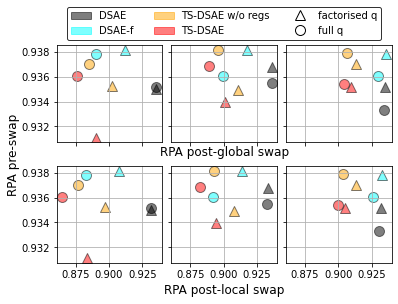

In [88]:
draw_local_acc('DMelodies', save_path='results/')

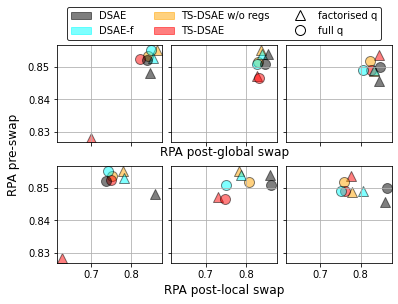

In [89]:
draw_local_acc('Urmp', legend=True, save_path='results')

In [91]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.patheffects as pe


def draw_fad(dataset, alpha=0.5, legend=True, save_path=None):
    df = pd.read_csv('results/final.csv')
    df['freeze'] = df_main.apply(lambda row: determine_method(row), axis=1)
    legend_elements = [
        Patch(color='k', label='DSAE', alpha=alpha),
        Patch(color='cyan', label='DSAE-f', alpha=alpha),
        Patch(color='orange', label='TS-DSAE w/o regs', alpha=alpha),
        Patch(color='red', label='TS-DSAE', alpha=alpha),
        Line2D([0], [0], marker='^', color='w', label='factorised q', markerfacecolor='w', markersize=10, markeredgecolor='k'),
        Line2D([0], [0], marker='o', color='w', label='full q', markerfacecolor='w', markersize=10, markeredgecolor='k')
    ]
    
    assert dataset in ['DMelodies', 'Urmp']
    fig, ax = plt.subplots(2, 3, figsize=(3*2, 2*2), sharex=True, sharey=True)
    for row in range(2):
        for col, d in enumerate([8, 16, 32]):
            dd = df[(df.z_dim == d) & (df.data == dataset)]
            arch = dd.arch.to_numpy()  # determine shape
            method = dd.freeze.to_numpy()  # determine color
            shapes = dd.apply(lambda x: map_arch_to_shape(x), axis=1).to_numpy()
            colors = dd.apply(lambda x: map_method_to_color(x), axis=1).to_numpy()

            y = dd.recon_fad.to_numpy()
            if row == 0:
                x = dd.post_g_acc.to_numpy()
            else:
                x = dd.post_l_acc.to_numpy()
            for i, j, k, l, a, m in zip(x, y, shapes, colors, arch, method):
                label = '-'.join([a, m])
                ax[row][col].scatter(i, j, marker=k, c=l, alpha=alpha, edgecolor='black', s=100)
    #             ax[row][col].set_xlim((0,1))
    #             ax[row][col].set_ylim((0.7,1))
                ax[row][col].grid(True)
            if row == 0 and col ==1:
                ax[row][col].set_xlabel('F1 post-global swap', fontsize=12)
            if row == 1 and col ==1:
                ax[row][col].set_xlabel('F1 post-local swap', fontsize=12)
            if legend:
                if row == 0 and col == 1:
                    ax[row][col].legend(
                        handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=[0.5, 1.45],
                        fancybox=True, fontsize='medium', edgecolor='k'
                    )
             
    plt.subplots_adjust(wspace=0.085, hspace=0.25)
    fig.text(0.04, 0.5, 'FAD', va='center', rotation='vertical', fontsize=12) 
    if save_path is not None:
        fname = '-'.join(['eval', dataset, 'recon'])
        fname +='.png'
        plt.savefig(Path(save_path) / fname, bbox_inches = "tight", dpi=300)

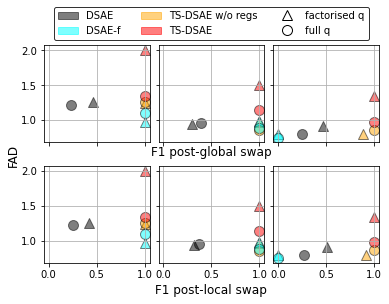

In [365]:
draw_fad('DMelodies', save_path='results/')

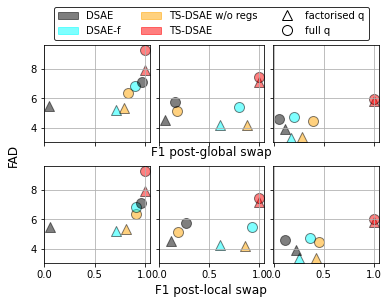

In [92]:
draw_fad('Urmp', save_path='results/', legend=True)

In [139]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.patheffects as pe



def draw_rich_acc(alpha=0.5, legend=True, save_path=None):
    legend_elements = [
        Patch(color='k', label='DSAE', alpha=alpha),
        Patch(color='red', label='TS-DSAE', alpha=alpha),
        Line2D([0], [0], marker='^', color='w', label='factorised q', markerfacecolor='w', markersize=10, markeredgecolor='k'),
        Line2D([0], [0], marker='*', color='w', label='rich factorised q', markerfacecolor='w', markersize=10, markeredgecolor='k')
    ]
    fig, ax = plt.subplots(2, 3, figsize=(3*2, 2*2), sharex=True, sharey='row')
    for row, dataset in enumerate(['DMelodies', 'Urmp']):
        for col, d in enumerate([df_comb.pre_swap_acc, df_comb.post_g_acc, df_comb.post_l_acc]):
            dd = df_comb[df_comb.data == dataset]
            
            method = dd.freeze.to_numpy()  # determine color
            arch = dd.likelihood.to_numpy()
            
            def map_arch_to_shape(x):
                if x.likelihood == '=':
                    return '*'
                elif x.likelihood == '0':
                    return '^'

            def map_method_to_color(x):
                if x.freeze == 'prgCycle':
                    return 'r'
                elif x.freeze == 'base':
                    return 'k'
            
            shapes = dd.apply(lambda x: map_arch_to_shape(x), axis=1).to_numpy()
            colors = dd.apply(lambda x: map_method_to_color(x), axis=1).to_numpy()

            y = dd.recon_fad.to_numpy()
            x = d

            for i, j, k, l, a, m in zip(x, y, shapes, colors, arch, method):
                label = '-'.join([a, m])
                ax[row][col].scatter(i, j, marker=k, c=l, alpha=alpha, edgecolor='black', s=100)
    #             ax[row][col].set_xlim((0,1))
    #             ax[row][col].set_ylim((0.7,1))
                ax[row][col].grid(True)
            
            if row == 1:
                if col == 0:
                    x_label = 'F1 pre-swap'
                elif col == 1:
                    x_label = 'F1 post-global swap'
                else:
                    x_label = 'F1 post-local swap'
                ax[row][col].set_xlabel(x_label, fontsize=11)
            
            if legend:
                if row == 0 and col == 1:
                    ax[row][col].legend(
                        handles=legend_elements, loc='upper center', ncol=2, bbox_to_anchor=[0.5, 1.45],
                        fancybox=True, fontsize='medium', edgecolor='k'
                    )
             
    plt.subplots_adjust(wspace=0.085, hspace=0.09)
    fig.text(0.04, 0.5, 'FAD', va='center', rotation='vertical', fontsize=12) 
    if save_path is not None:
        fname = '-'.join(['eval', 'rich'])
        fname +='.png'
        plt.savefig(Path(save_path) / fname, bbox_inches = "tight", dpi=300)

In [10]:
df_rich = pd.read_csv('results/factor_rich.csv')
df_main = pd.read_csv('results/final.csv')
df_rich['likelihood'] = '='
df_main['likelihood'] = '0'
df_main['freeze'] = df_main.apply(lambda row: determine_method(row), axis=1)
df_rich['freeze'] = df_rich.apply(lambda row: determine_method(row), axis=1)
df_main_filter = df_main[(df_main.freeze.isin(['base', 'prgCycle'])) & (df_main.z_dim == 16) & (df_main.arch == 'DSA')]
df_comb = pd.concat([df_main_filter, df_rich], ignore_index=True)

In [11]:
df_comb

Unnamed: 0                                               ckpt       run  \
0           1  multirun/2021-12-25/21-46-06/1/wandb/run-20211...  3qqrafr3   
1          19  multirun/2021-12-26/19-53-14/1/wandb/run-20211...  2wywcz7e   
2          28  multirun/2021-12-28/17-14-43/1/wandb/run-20211...  100rp4l2   
3          31  multirun/2021-12-28/17-15-18/1/wandb/run-20211...  10w9zkus   
4           0  multirun/2022-01-06/02-16-41/0/wandb/run-20220...  34o1ona0   
5           1  multirun/2022-01-06/02-16-41/1/wandb/run-20220...  1ifx0em0   

   epoch                                  model    prg       data  z_dim arch  \
0   3910  src.models.prgCycle_dvae.PrgCycleDVAE   True       Urmp     16  DSA   
1   3941             src.models.dvae.SimpleDVAE  False       Urmp     16  DSA   
2   3968  src.models.prgCycle_dvae.PrgCycleDVAE   True  DMelodies     16  DSA   
3   3985             src.models.dvae.SimpleDVAE  False  DMelodies     16  DSA   
4   3893  src.models.prgCycle_dvae.PrgCycleDVAE   True  DMelodies     16  DSA   
5   3998  src.models.prgCycle_dvae.PrgCycleDVAE   True       Urmp     16  DSA   

   pre_swap_acc  ...  post_g_rpa  post_l_rpa  pre_swap_rca  post_g_rca  \
0      1.000000  ...    0.827553    0.730547      0.852654    0.836416   
1      0.915282  ...    0.853502    0.860237      0.857428    0.857098   
2      1.000000  ...    0.901385    0.894276      0.934682    0.902466   
3      0.677306  ...    0.936553    0.933166      0.937390    0.937200   
4      1.000000  ...    0.847923    0.834611      0.937238    0.850751   
5      1.000000  ...    0.832671    0.748896      0.855021    0.841768   

   post_l_rca  recon_fad  likelihood    freeze  \
0    0.737081   7.150756           0  prgCycle   
1    0.861938   4.547467           0      base   
2    0.895355   1.495380           0  prgCycle   
3    0.933775   0.941319           0      base   
4    0.837427   0.593554           =  prgCycle   
5    0.755443   5.224781           =  prgCycle   

                                           data_path switch_epoch  
0                                                NaN          NaN  
1                                                NaN          NaN  
2                                                NaN          NaN  
3                                                NaN          NaN  
4  data/dmelodies_dataset/wav_datasets/C_4_major-...        300.0  
5  /import/c4dm-datasets/URMP/synth-dataset/4s-da...        300.0  

[6 rows x 23 columns]

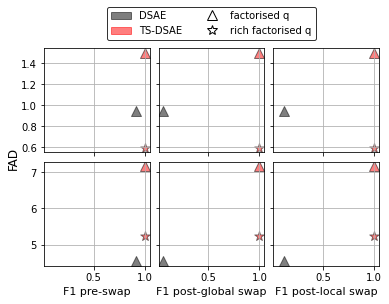

In [141]:
draw_rich_acc(alpha=0.5, legend=True, save_path='results/')

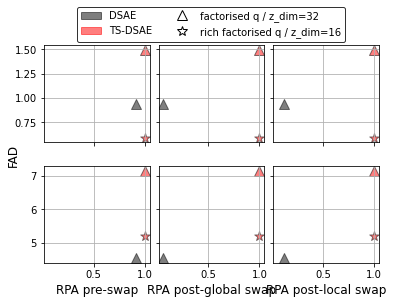

In [118]:
draw_rich_acc(alpha=0.5, legend=True, save_path=None)

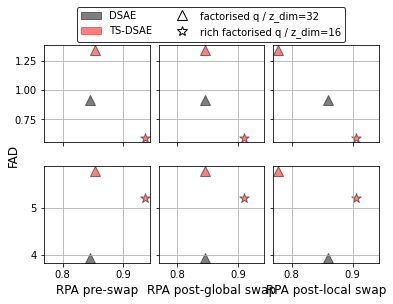

In [112]:
df_rich = pd.read_csv('results/factor_rich.csv')
df_main = pd.read_csv('results/final.csv')
df_rich['likelihood'] = '='
df_main['likelihood'] = '0'
df_main['freeze'] = df_main.apply(lambda row: determine_method(row), axis=1)
df_rich['freeze'] = df_rich.apply(lambda row: determine_method(row), axis=1)
df_main_filter = df_main[(df_main.freeze.isin(['base', 'prgCycle'])) & (df_main.z_dim == 32) & (df_main.arch == 'DSA')]
df_comb = pd.concat([df_main_filter, df_rich], ignore_index=True)
draw_rich_acc(alpha=0.5, legend=True, save_path=None)

In [142]:
multiple_factorised_ckpt = 'multirun/2022-01-06/03-07-40/0/wandb/run-20220106_030745-22mh6z7c/files/dvae/22mh6z7c/checkpoints/epoch=3996-step=75942.ckpt'
multiple_rich_ckpt = 'multirun/2022-01-06/03-07-40/1/wandb/run-20220106_030745-3j9d4eqn/files/dvae/3j9d4eqn/checkpoints/epoch=2211-step=42027.ckpt'

In [148]:
def get_cfg_from_ckpt(ckpt):
    param = list(Path(ckpt.parents[4]).rglob('hparams.yaml'))
    assert len(param) == 1
    param = param[0]

    return OmegaConf.load(param)

def load_model(ckpt):
    cfg = get_cfg_from_ckpt(ckpt)
    seed_everything(cfg.train.random_seed)
    model: pl.LightningModule = hydra.utils.instantiate(
        cfg.model,
        optim=cfg.optim,
        data=cfg.data,
        logging=cfg.logging,
        _recursive_=False,
    )
    model = model.load_from_checkpoint(ckpt, strict=False)
    model.to(device)
    model.eval()
    return model

def load_dataset(cfg):
    datamodule: pl.LightningDataModule = hydra.utils.instantiate(cfg.data, _recursive_=False)
    datamodule.setup()
    return datamodule

In [163]:
rich_data

'data/dmelodies_dataset/wav_datasets/C_major-roFilter-vn_tp-3000/train'

In [164]:
factorised = load_model(Path(multiple_factorised_ckpt))
rich = load_model(Path(multiple_rich_ckpt))

factorised_cfg = get_cfg_from_ckpt(Path(multiple_factorised_ckpt))
factorised_data = factorised_cfg.data.datasets.train.path_to_data

rich_cfg = get_cfg_from_ckpt(Path(multiple_rich_ckpt))
rich_data = rich_cfg.data.datasets.train.path_to_data
assert factorised_data == rich_data

datamodule = load_dataset(factorised_cfg)

Global seed set to 42
Global seed set to 42
/homes/yl006/projects/dvae-lib/.venv/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Dataset already created. Reading it now
Dataset already created. Reading it now


In [177]:
input_s = []
input_reversed_s = []
mask_s = []
seq_lengths_s = []
labels_s = []
for n, batch in enumerate(datamodule.val_dataloader()):
    input, input_reversed, mask, seq_lengths, labels = batch
    input_s.append(input)
    input_reversed_s.append(input_reversed)
    mask_s.append(mask)
    seq_lengths_s.append(seq_lengths)
    labels_s.append(labels)
input = torch.vstack(input_s)
input_reversed = torch.vstack(input_reversed_s)
mask = torch.vstack(mask_s)
seq_lengths = torch.hstack(seq_lengths_s)
labels = torch.vstack(labels_s)

In [250]:
both_diff_idx

tensor([37])

In [278]:
t = 500
print(octave_label[t])
print(inst_label[t])

tensor(0)
tensor(3)


tensor(4)

In [253]:
labels[101]

tensor([0, 1, 0, 0, 9, 0, 0, 1, 1, 4])

In [291]:
print(labels[pick], pick)
print(labels[both_diff_idx], both_diff_idx)
print(labels[octave_diff_idx], octave_diff_idx)
print(labels[inst_diff_idx], inst_diff_idx)

tensor([ 0,  1,  0,  1, 16,  1,  0,  0,  1,  4]) 120
tensor([0, 0, 0, 5, 5, 0, 1, 0, 0, 3]) 500
tensor([ 0,  0,  0, 10, 27,  1,  1,  0,  0,  4]) tensor(105)
tensor([ 0,  1,  0, 16, 14,  1,  0,  1,  1,  3]) tensor(559)


In [285]:
octave_label = labels[:, 1]
inst_label = labels[:, -1]

def get_paired_seq_idx(global_label):
    sampled_idx = torch.empty_like(global_label)
    for i, y in enumerate(global_label):
        candidate_idx = torch.where(global_label != y)[0]
        chosen = torch.multinomial(
            torch.ones_like(candidate_idx, dtype=float), 1
        )
        sampled_idx[i] = candidate_idx[chosen]
    return sampled_idx.squeeze(-1)

pick = 120
both_diff_idx = 500
octave_diff_idx = get_paired_seq_idx(octave_label)[pick]
inst_diff_idx = get_paired_seq_idx(inst_label)[pick]

with torch.no_grad():
    rich_outputs = rich.forward(
        input.to(device),
        input_reversed.to(device),
        seq_lengths.to(device),
        mask.to(device), 
        deterministic=True
    )
    
with torch.no_grad():
    factorised_outputs = factorised.forward(
        input.to(device),
        input_reversed.to(device),
        seq_lengths.to(device),
        mask.to(device), 
        deterministic=True
    )

In [286]:
rich_swap_octave = rich.decode(
    rich_outputs['posterior'][pick].unsqueeze(0),
    rich_outputs['content_mu_aggr'][octave_diff_idx].unsqueeze(0),
    seq_lengths=rich_outputs['seq_lengths'][pick].unsqueeze(0)
)
factorised_swap_octave = rich.decode(
    factorised_outputs['posterior'][pick].unsqueeze(0),
    factorised_outputs['content_mu_aggr'][octave_diff_idx].unsqueeze(0),
    seq_lengths=factorised_outputs['seq_lengths'][pick].unsqueeze(0)
)

rich_swap_inst = rich.decode(
    rich_outputs['posterior'][pick].unsqueeze(0),
    rich_outputs['content_mu_aggr'][inst_diff_idx].unsqueeze(0),
    seq_lengths=rich_outputs['seq_lengths'][pick].unsqueeze(0)
)
factorised_swap_inst = rich.decode(
    factorised_outputs['posterior'][pick].unsqueeze(0),
    factorised_outputs['content_mu_aggr'][inst_diff_idx].unsqueeze(0),
    seq_lengths=factorised_outputs['seq_lengths'][pick].unsqueeze(0)
)

rich_swap_both = rich.decode(
    rich_outputs['posterior'][pick].unsqueeze(0),
    rich_outputs['content_mu_aggr'][both_diff_idx].unsqueeze(0),
    seq_lengths=rich_outputs['seq_lengths'][pick].unsqueeze(0)
)
factorised_swap_both = rich.decode(
    factorised_outputs['posterior'][pick].unsqueeze(0),
    factorised_outputs['content_mu_aggr'][both_diff_idx].unsqueeze(0),
    seq_lengths=factorised_outputs['seq_lengths'][pick].unsqueeze(0)
)

In [310]:
rich_swap_octave.size()

torch.Size([1, 251, 80])

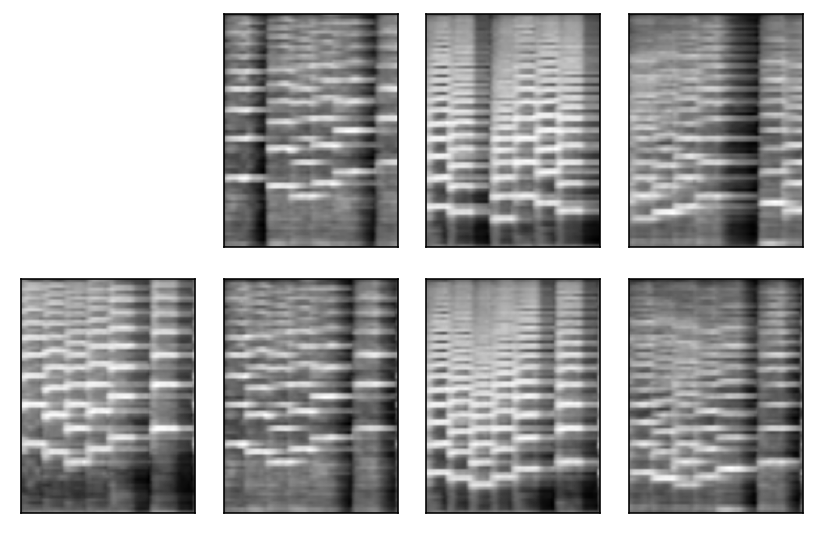

In [328]:
fig, ax = plt.subplots(2, 4, figsize=(4 * 1.5, 2 * 2), sharex=True, sharey=True)
T = 125

ax[0][1].imshow(rich_outputs['reconstruction'][inst_diff_idx][:T].unsqueeze(0).cpu().detach().numpy()[0].T, origin='lower', aspect='auto', cmap="gray")
ax[0][2].imshow(rich_outputs['reconstruction'][octave_diff_idx][:T].unsqueeze(0).cpu().detach().numpy()[0].T, origin='lower', aspect='auto', cmap="gray")
ax[0][3].imshow(rich_outputs['reconstruction'][both_diff_idx][:T].unsqueeze(0).cpu().detach().numpy()[0].T, origin='lower', aspect='auto', cmap="gray")


ax[1][0].imshow(rich_outputs['reconstruction'][pick][:T].unsqueeze(0).cpu().detach().numpy()[0].T, origin='lower', aspect='auto', cmap="gray")
ax[1][1].imshow(rich_swap_inst[:,:T,:].cpu().detach().numpy()[0].T, origin='lower', aspect='auto', cmap="gray")

ax[1][2].imshow(rich_swap_octave[:,:T,:].cpu().detach().numpy()[0].T, origin='lower', aspect='auto', cmap="gray")
ax[1][3].imshow(rich_swap_both[:,:T,:].cpu().detach().numpy()[0].T, origin='lower', aspect='auto', cmap="gray")
plt.tight_layout()
ax[0,0].set_axis_off()
for i in ax:
    for j in i:
        j.set_xticks([])
        j.set_yticks([])
plt.savefig('results/multiple.png', dpi=500, bbox_inches = "tight")

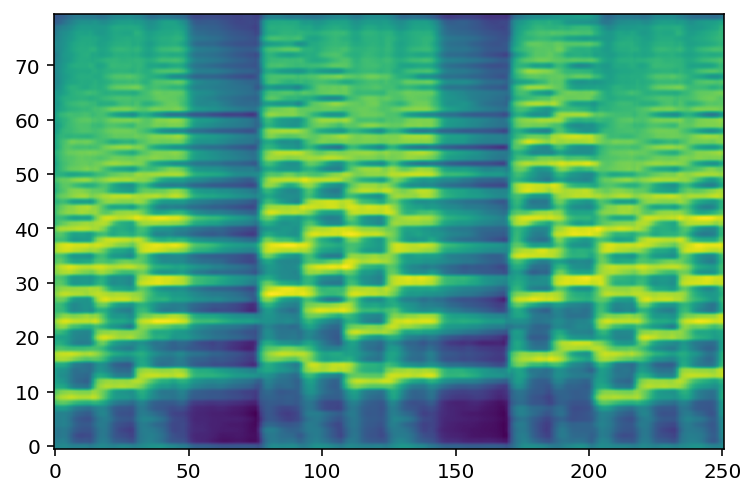

In [227]:
plt.imshow

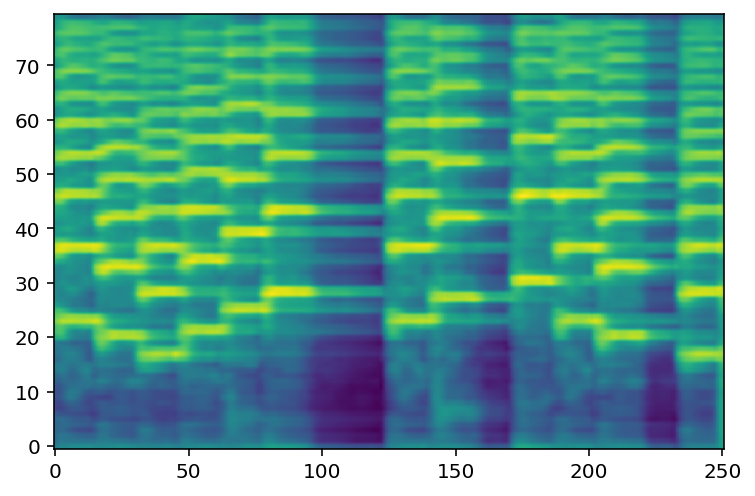

In [208]:
plt.imshow(swap_octave.cpu().detach().numpy()[0].T, origin='lower', aspect='auto')

In [14]:
df

ckpt       run epoch  \
0  multirun/2022-01-02/01-52-08/0/wandb/run-20220...  35gzw536  3996   

                                   model   prg       data  z_dim arch  \
0  src.models.prgCycle_dvae.PrgCycleDVAE  True  DMelodies     16  DSA   

   switch_epoch  pre_swap_acc  post_g_acc  post_l_acc  pre_swap_rpa  \
0           300           1.0         1.0         1.0      0.949324   

   post_g_rpa  post_l_rpa  pre_swap_rca  post_g_rca  post_l_rca  recon_fad  
0    0.496549    0.495744      0.951449    0.914708    0.908985   5.789283

In [15]:
df.to_csv('results/2d.csv')df.to_pickle('results/2d.pkl')

In [29]:
Path(df.iloc[:,0].to_numpy()[0]).parents[2]

PosixPath('multirun/2021-12-25/21-46-06/0/wandb/run-20211225_214611-2be77isf/files/dvae')

In [40]:
df

ckpt       run epoch  \
0   multirun/2021-12-25/21-46-06/0/wandb/run-20211...  2be77isf  3958   
1   multirun/2021-12-25/21-46-06/1/wandb/run-20211...  3qqrafr3  3910   
2   multirun/2021-12-25/21-46-06/2/wandb/run-20211...  16iep6ur  3729   
3   multirun/2021-12-25/21-46-09/0/wandb/run-20211...  2lh097zo  3970   
4   multirun/2021-12-25/21-46-09/1/wandb/run-20211...  1p19ejbm  3988   
5   multirun/2021-12-25/21-46-09/2/wandb/run-20211...  1dfx5rjw  3939   
6   multirun/2021-12-26/00-10-22/0/wandb/run-20211...  cxwm5bc8  3981   
7   multirun/2021-12-26/00-10-22/1/wandb/run-20211...  2vg8963c  3998   
8   multirun/2021-12-26/00-10-22/2/wandb/run-20211...  lr3cngln  3997   
9   multirun/2021-12-26/01-01-06/0/wandb/run-20211...  250q1fm4  3985   
10  multirun/2021-12-26/01-01-06/1/wandb/run-20211...  1vrwgz5w  3895   
11  multirun/2021-12-26/01-01-06/2/wandb/run-20211...  1v7cbez3  3932   
12  multirun/2021-12-26/09-51-13/0/wandb/run-20211...  30dhx2dj  3972   
13  multirun/2021-12-26/09-51-13/1/wandb/run-20211...  314tgmxi  3996   
14  multirun/2021-12-26/09-51-13/2/wandb/run-20211...  3goato76  3965   
15  multirun/2021-12-26/12-21-22/0/wandb/run-20211...  fjauyu4a  3998   
16  multirun/2021-12-26/12-21-22/1/wandb/run-20211...  bvxk5sq6  3958   
17  multirun/2021-12-26/12-21-22/2/wandb/run-20211...  22uedz2x  3979   
18  multirun/2021-12-26/19-53-14/0/wandb/run-20211...  3hnzkb7m  3973   
19  multirun/2021-12-26/19-53-14/1/wandb/run-20211...  2wywcz7e  3941   
20  multirun/2021-12-26/19-53-14/2/wandb/run-20211...  3tj5pj5t  3965   
21  multirun/2021-12-27/17-21-18/0/wandb/run-20211...  28et6h4t  3998   
22  multirun/2021-12-27/17-21-18/1/wandb/run-20211...  6xrzy35o  3998   
23  multirun/2021-12-27/17-21-18/2/wandb/run-20211...  3sbgu7r5  3992   
24  multirun/2021-12-28/17-12-23/0/wandb/run-20211...  1m27jh4i  3989   
25  multirun/2021-12-28/17-12-23/1/wandb/run-20211...  2mkdcpy0  3989   
26  multirun/2021-12-28/17-12-23/2/wandb/run-20211...  2zdio16i  3979   
27  multirun/2021-12-28/17-14-43/0/wandb/run-20211...  3kv3s4yj  3952   
28  multirun/2021-12-28/17-14-43/1/wandb/run-20211...  100rp4l2  3968   
29  multirun/2021-12-28/17-14-43/2/wandb/run-20211...  rqp52t82  3986   
30  multirun/2021-12-28/17-15-18/0/wandb/run-20211...  1bn68xrn  3999   
31  multirun/2021-12-28/17-15-18/1/wandb/run-20211...  10w9zkus  3985   
32  multirun/2021-12-28/17-15-18/2/wandb/run-20211...  3fchtlf5  3986   
33  multirun/2021-12-28/17-19-14/0/wandb/run-20211...  2u9rb7yi  3965   
34  multirun/2021-12-28/17-19-14/1/wandb/run-20211...  e35nc3ms  3995   
35  multirun/2021-12-28/17-19-14/2/wandb/run-20211...  1w1jcstn  3987   
36  multirun/2021-12-28/20-11-30/0/wandb/run-20211...  2l86x43s  3849   
37  multirun/2021-12-28/20-11-30/1/wandb/run-20211...  1ohnn5wt  3986   
38  multirun/2021-12-28/20-11-30/2/wandb/run-20211...  2u7fwltf  3996   
39  multirun/2021-12-28/20-22-12/0/wandb/run-20211...  34g38uwb  3989   
40  multirun/2021-12-28/20-22-12/1/wandb/run-20211...  2pqxm67d  3975   
41  multirun/2021-12-28/20-22-12/2/wandb/run-20211...  j5n7y47j  3990   
42  multirun/2021-12-28/20-40-35/0/wandb/run-20211...  2qsh4xlo  3997   
43  multirun/2021-12-28/20-40-35/1/wandb/run-20211...  ycqdxvah  3992   
44  multirun/2021-12-28/20-40-35/2/wandb/run-20211...  3nyjwn36  3997   
45  multirun/2021-12-28/20-56-46/0/wandb/run-20211...  3rh0zxfp  3925   
46  multirun/2021-12-28/20-56-46/1/wandb/run-20211...  3gkv0ad5  3203   
47  multirun/2021-12-28/20-56-46/2/wandb/run-20211...  2twv6s7q  3996   

                                    model    prg       data  z_dim      arch  \
0   src.models.prgCycle_dvae.PrgCycleDVAE   True       Urmp      8       DSA   
1   src.models.prgCycle_dvae.PrgCycleDVAE   True       Urmp     16       DSA   
2   src.models.prgCycle_dvae.PrgCycleDVAE   True       Urmp     32       DSA   
3             src.models.prg_dvae.PrgDVAE   True       Urmp      8       DSA   
4             src.models.prg_dvae.PrgDVAE   True       Urmp     16     

In [39]:
df

ckpt       run epoch  \
0   multirun/2021-12-25/21-46-06/0/wandb/run-20211...  2be77isf  3958   
1   multirun/2021-12-25/21-46-06/1/wandb/run-20211...  3qqrafr3  3910   
2   multirun/2021-12-25/21-46-06/2/wandb/run-20211...  16iep6ur  3729   
3   multirun/2021-12-25/21-46-09/0/wandb/run-20211...  2lh097zo  3970   
4   multirun/2021-12-25/21-46-09/1/wandb/run-20211...  1p19ejbm  3988   
5   multirun/2021-12-25/21-46-09/2/wandb/run-20211...  1dfx5rjw  3939   
6   multirun/2021-12-26/00-10-22/0/wandb/run-20211...  cxwm5bc8  3981   
7   multirun/2021-12-26/00-10-22/1/wandb/run-20211...  2vg8963c  3998   
8   multirun/2021-12-26/00-10-22/2/wandb/run-20211...  lr3cngln  3997   
9   multirun/2021-12-26/01-01-06/0/wandb/run-20211...  250q1fm4  3985   
10  multirun/2021-12-26/01-01-06/1/wandb/run-20211...  1vrwgz5w  3895   
11  multirun/2021-12-26/01-01-06/2/wandb/run-20211...  1v7cbez3  3932   
12  multirun/2021-12-26/09-51-13/0/wandb/run-20211...  30dhx2dj  3972   
13  multirun/2021-12-26/09-51-13/1/wandb/run-20211...  314tgmxi  3996   
14  multirun/2021-12-26/09-51-13/2/wandb/run-20211...  3goato76  3965   
15  multirun/2021-12-26/12-21-22/0/wandb/run-20211...  fjauyu4a  3998   
16  multirun/2021-12-26/12-21-22/1/wandb/run-20211...  bvxk5sq6  3958   
17  multirun/2021-12-26/12-21-22/2/wandb/run-20211...  22uedz2x  3979   
18  multirun/2021-12-26/19-53-14/0/wandb/run-20211...  3hnzkb7m  3973   
19  multirun/2021-12-26/19-53-14/1/wandb/run-20211...  2wywcz7e  3941   
20  multirun/2021-12-26/19-53-14/2/wandb/run-20211...  3tj5pj5t  3965   
21  multirun/2021-12-27/17-21-18/0/wandb/run-20211...  28et6h4t  3998   
22  multirun/2021-12-27/17-21-18/1/wandb/run-20211...  6xrzy35o  3998   
23  multirun/2021-12-27/17-21-18/2/wandb/run-20211...  3sbgu7r5  3992   
24  multirun/2021-12-28/17-12-23/0/wandb/run-20211...  1m27jh4i  3989   
25  multirun/2021-12-28/17-12-23/1/wandb/run-20211...  2mkdcpy0  3989   
26  multirun/2021-12-28/17-12-23/2/wandb/run-20211...  2zdio16i  3979   
27  multirun/2021-12-28/17-14-43/0/wandb/run-20211...  3kv3s4yj  3952   
28  multirun/2021-12-28/17-14-43/1/wandb/run-20211...  100rp4l2  3968   
29  multirun/2021-12-28/17-14-43/2/wandb/run-20211...  rqp52t82  3986   
30  multirun/2021-12-28/17-15-18/0/wandb/run-20211...  1bn68xrn  3999   
31  multirun/2021-12-28/17-15-18/1/wandb/run-20211...  10w9zkus  3985   
32  multirun/2021-12-28/17-15-18/2/wandb/run-20211...  3fchtlf5  3986   
33  multirun/2021-12-28/17-19-14/0/wandb/run-20211...  2u9rb7yi  3965   
34  multirun/2021-12-28/17-19-14/1/wandb/run-20211...  e35nc3ms  3995   
35  multirun/2021-12-28/17-19-14/2/wandb/run-20211...  1w1jcstn  3987   
36  multirun/2021-12-28/20-11-30/0/wandb/run-20211...  2l86x43s  3849   
37  multirun/2021-12-28/20-11-30/1/wandb/run-20211...  1ohnn5wt  3986   
38  multirun/2021-12-28/20-11-30/2/wandb/run-20211...  2u7fwltf  3996   
39  multirun/2021-12-28/20-22-12/0/wandb/run-20211...  34g38uwb  3989   
40  multirun/2021-12-28/20-22-12/1/wandb/run-20211...  2pqxm67d  3975   
41  multirun/2021-12-28/20-22-12/2/wandb/run-20211...  j5n7y47j  3990   
42  multirun/2021-12-28/20-40-35/0/wandb/run-20211...  2qsh4xlo  3997   
43  multirun/2021-12-28/20-40-35/1/wandb/run-20211...  ycqdxvah  3992   
44  multirun/2021-12-28/20-40-35/2/wandb/run-20211...  3nyjwn36  3997   
45  multirun/2021-12-28/20-56-46/0/wandb/run-20211...  3rh0zxfp  3925   
46  multirun/2021-12-28/20-56-46/1/wandb/run-20211...  3gkv0ad5  3203   
47  multirun/2021-12-28/20-56-46/2/wandb/run-20211...  2twv6s7q  3996   

                                    model    prg       data  z_dim      arch  \
0   src.models.prgCycle_dvae.PrgCycleDVAE   True       Urmp      8       DSA   
1   src.models.prgCycle_dvae.PrgCycleDVAE   True       Urmp     16       DSA   
2   src.models.prgCycle_dvae.PrgCycleDVAE   True       Urmp     32       DSA   
3             src.models.prg_dvae.PrgDVAE   True       Urmp      8       DSA   
4             src.models.prg_dvae.PrgDVAE   True       Urmp     16     

In [391]:
import pandas as pd

In [ ]:
sampled_idx

In [394]:
pwd

'/homes/yl006/projects/dvae-lib/notebook'

In [396]:
df = pd.read_pickle('../results/complete_update.pkl')

In [11]:
import numpy

def determine_arch(row):
    p = row['prior']
    q = row['feature']
    c = row['content_condition']
    assert isinstance(p, str)
    assert isinstance(q, str)
    assert isinstance(c, bool)
    if (p == '0') and (q == '0') and (not c):
        return 'Static'
    elif (p == '2') and (q == '0') and (not c):
        return 'Dynamic'
    elif (p == '2') and (q == '=') and (not c):
        return 'DSAE'
    elif (p == '2') and (q == '=') and (c):
        return 'DSAE(full)'
    else:
        raise ValueError
        
def determine_method(row):
    prg = row['progressive']
    drop = row['drop_rate']
    deterministic_content = row['deterministic_content']
    freeze_global_on_switch = row['freeze_global_on_switch']
    assert isinstance(prg, bool)
    assert isinstance(drop, float)
    assert isinstance(deterministic_content, bool)
    assert isinstance(freeze_global_on_switch, bool)

    if deterministic_content:
        return 'AE'
    elif freeze_global_on_switch:
        if drop != 0:
            return 'freeze-drop'
        else:
            return 'freeze'
    elif (prg) and (drop != 0):
        return 'prg-drop'
    elif (prg) and (drop == 0):
        return 'prg'
    elif (not prg) and (drop == 0):
        return 'base'
    elif (not prg) and (drop != 0):
        return 'drop'
    else:
        raise ValueError

In [12]:
df['arch'] = df.apply(lambda row: determine_arch(row), axis=1)
df['method'] = df.apply(lambda row: determine_method(row), axis=1)

In [16]:
df

path       run  data epoch  \
0   multirun/2021-11-13/09-47-24/0/wandb/run-20211...  2iw0grnc  Urmp  2988   
1   multirun/2021-11-13/09-47-24/1/wandb/run-20211...  7vv2xbyz  Urmp  2977   
2   multirun/2021-11-13/09-47-24/2/wandb/run-20211...  3obs998q  Urmp  2996   
3   multirun/2021-11-13/09-47-27/0/wandb/run-20211...  13juwnn9  Urmp  2994   
4   multirun/2021-11-13/09-47-27/1/wandb/run-20211...  2ia7u45e  Urmp  2996   
..                                                ...       ...   ...   ...   
61  multirun/2021-11-14/02-31-49/1/wandb/run-20211...  20e7uot5  Urmp  2993   
62  multirun/2021-11-14/02-31-49/2/wandb/run-20211...  6znfc3wi  Urmp  2999   
63  multirun/2021-11-14/07-12-35/0/wandb/run-20211...  25sla3yw  Urmp  2983   
64  multirun/2021-11-14/07-12-35/1/wandb/run-20211...  lwsh63hm  Urmp  2971   
65  multirun/2021-11-14/07-12-35/2/wandb/run-20211...  1v3n5dx0  Urmp  2988   

    z_dim  progressive  drop_rate prior feature  content_condition  \
0       8        False        0.0     0       0              False   
1      16        False        0.0     0       0              False   
2      32        False        0.0     0       0              False   
3       8        False        0.0     2       0              False   
4      16        False        0.0     2       0              False   
..    ...          ...        ...   ...     ...                ...   
61     16         True        0.0     2       =              False   
62     32         True        0.0     2       =              False   
63      8         True        0.2     2       =              False   
64     16         True        0.2     2       =              False   
65     32         True        0.2     2       =              False   

    deterministic_content  freeze_global_on_switch  pre_swap  post_g_swap  \
0                   False                    False  1.000000     1.000000   
1                   False                    False  0.992308     0.007692   
2                   False                    False  0.926923     0.073077   
3                   False                    False  0.926923     0.073077   
4                   False                    False  0.965385     0.034615   
..                    ...                      ...       ...          ...   
61                  False                     True  0.996154     0.711538   
62                  False                     True  0.996154     0.288462   
63                  False                     True  0.988462     0.984615   
64                  False                     True  1.000000     0.973077   
65                  False                     True  0.996154     0.861538   

    post_l_swap     arch       method  
0      1.000000   Static         base  
1      0.007692   Static         base  
2      0.130769   Static         base  
3      0.226923  Dynamic         base  
4      0.088462  Dynamic         base  
..          ...      ...          ...  
61     0.780769     DSAE       freeze  
62     0.496154     DSAE       freeze  
63     0.976923     DSAE  freeze-drop  
64     0.965385     DSAE  freeze-drop  
65     0.946154     DSAE  freeze-drop  

[66 rows x 17 columns]

Text(0.5, -0.1, 'architecture')

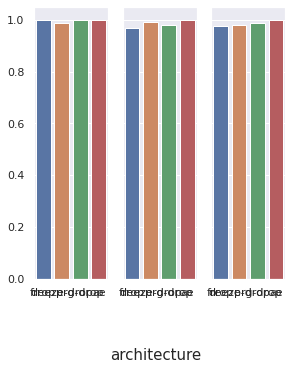

Text(0.5, 0.01, 'architecture')

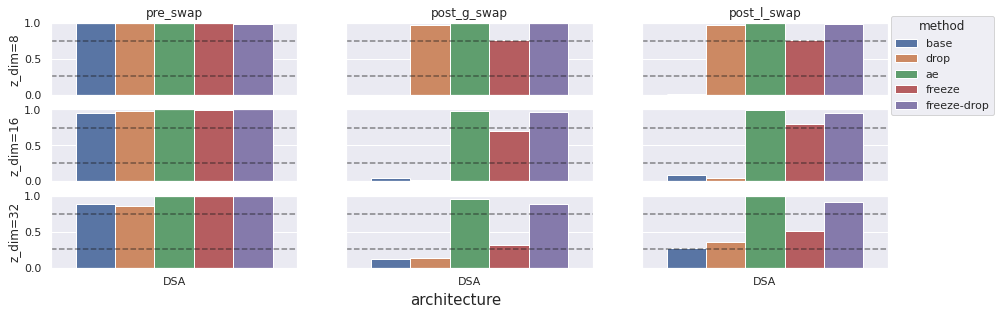

In [476]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

p_neg = 1 - sum(datamodule.train_dataset.label) / len((datamodule.train_dataset.label))
n_dim = len(set(df.z_dim))
metrics = ['pre_swap', 'post_g_swap', 'post_l_swap']
methods = ['DSA']
n_metric = len(metrics)

fig, ax = plt.subplots(n_dim, n_metric, figsize=(n_metric * 5, n_dim * 1.5), sharex=True, sharey=True)

for i, dim in enumerate(set(df.z_dim)):
    data = df[
        (df.z_dim == dim) & 
        (df.method != 'freeze') & 
        (df.method != 'freeze-drop') & 
        (df.method != 'prg') &
        (df.method != 'prg-drop')
    ]
    for j, met in enumerate(metrics):
        g = sns.barplot(
            data=data,
            x='arch', y=met, hue='method', order=methods,
            ax=ax[i][j]
        )
        g.axhline(p_neg, color='k', linestyle='--', alpha=0.5)
        g.axhline(1 - p_neg, color='k', linestyle='--', alpha=0.5)
        g.set_ylim([0, 1])
        g.get_legend().remove()
        g.set_xlabel("")
        g.set_ylabel("")
        if j % n_metric == 0:
            g.set_ylabel(f"z_dim={dim}", fontsize=12)
        if i == 0:
            g.set_title(f"{met}")

plt.legend(title="method", bbox_to_anchor=(1.01, 3.5), loc=2, borderaxespad=0., fancybox=True)


fig.text(0.5, 0.01, 'architecture', ha='center', fontsize=15)

In [406]:
df[(df.z_dim==32) & (df.method=='freeze-drop') & (df.arch=='DSA')]

path       run  data epoch  \
65  multirun/2021-11-14/07-12-35/2/wandb/run-20211...  1v3n5dx0  Urmp  2988   

    z_dim  progressive  drop_rate prior feature  content_condition  \
65     32         True        0.2     2       =              False   

    deterministic_content  freeze_global_on_switch  pre_swap  post_g_swap  \
65                  False                     True  0.996154     0.888462   

    post_l_swap  fad_recon  fad_sample arch       method  
65     0.911538   3.912762    3.288169  DSA  freeze-drop

In [401]:
df[(df.z_dim==8) & (df.method=='freeze-drop') & (df.arch=='DSA')]

path       run  data epoch  \
63  multirun/2021-11-14/07-12-35/0/wandb/run-20211...  25sla3yw  Urmp  2983   

    z_dim  progressive  drop_rate prior feature  content_condition  \
63      8         True        0.2     2       =              False   

    deterministic_content  freeze_global_on_switch  pre_swap  post_g_swap  \
63                  False                     True  0.988462     0.992308   

    post_l_swap  fad_recon  fad_sample arch       method  
63     0.980769   5.077091    3.403848  DSA  freeze-drop

In [73]:
data[data.method == 'ae']

path       run  data epoch  \
35  multirun/2021-11-13/17-20-41/2/wandb/run-20211...  3jpzvylo  Urmp  2996   
41  multirun/2021-11-13/19-07-51/2/wandb/run-20211...  3egjz1cl  Urmp  2986   
50  multirun/2021-11-13/21-37-52/2/wandb/run-20211...  3ambjgca  Urmp  2986   
59  multirun/2021-11-14/01-19-29/2/wandb/run-20211...  1243brzk  Urmp  2992   

    z_dim  progressive  drop_rate prior feature  content_condition  \
35     32        False        0.0     0       0              False   
41     32        False        0.0     2       0              False   
50     32        False        0.0     2       =              False   
59     32        False        0.0     2       =               True   

    deterministic_content  freeze_global_on_switch  pre_swap  post_g_swap  \
35                   True                    False       1.0     1.000000   
41                   True                    False       1.0     0.961538   
50                   True                    False       1.0     0.946154   
59                   True                    False       1.0     0.961538   

    post_l_swap  fad_recon  fad_sample       arch method  
35     1.000000   3.383516   11.572729     static     ae  
41     0.984615   3.294961    5.578584    dynamic     ae  
50     0.988462   3.279835    4.791190        DSA     ae  
59     0.938462   3.381547    5.352842  DSA(full)     ae

In [71]:
data[data.method == 'ae']

path       run  data epoch  \
35  multirun/2021-11-13/17-20-41/2/wandb/run-20211...  3jpzvylo  Urmp  2996   
41  multirun/2021-11-13/19-07-51/2/wandb/run-20211...  3egjz1cl  Urmp  2986   
50  multirun/2021-11-13/21-37-52/2/wandb/run-20211...  3ambjgca  Urmp  2986   
59  multirun/2021-11-14/01-19-29/2/wandb/run-20211...  1243brzk  Urmp  2992   

    z_dim  progressive  drop_rate prior feature  content_condition  \
35     32        False        0.0     0       0              False   
41     32        False        0.0     2       0              False   
50     32        False        0.0     2       =              False   
59     32        False        0.0     2       =               True   

    deterministic_content  freeze_global_on_switch  pre_swap  post_g_swap  \
35                   True                    False       1.0     1.000000   
41                   True                    False       1.0     0.961538   
50                   True                    False       1.0     0.946154   
59                   True                    False       1.0     0.961538   

    post_l_swap  fad_recon  fad_sample       arch method  
35     1.000000   3.383516   11.572729     static     ae  
41     0.984615   3.294961    5.578584    dynamic     ae  
50     0.988462   3.279835    4.791190        DSA     ae  
59     0.938462   3.381547    5.352842  DSA(full)     ae

In [20]:
df

ckpt       run epoch  \
0   multirun/2021-12-25/21-46-06/0/wandb/run-20211...  2be77isf  3958   
1   multirun/2021-12-25/21-46-06/1/wandb/run-20211...  3qqrafr3  3910   
2   multirun/2021-12-25/21-46-06/2/wandb/run-20211...  16iep6ur  3729   
3   multirun/2021-12-25/21-46-09/0/wandb/run-20211...  2lh097zo  3970   
4   multirun/2021-12-25/21-46-09/1/wandb/run-20211...  1p19ejbm  3988   
5   multirun/2021-12-25/21-46-09/2/wandb/run-20211...  1dfx5rjw  3939   
6   multirun/2021-12-26/00-10-22/0/wandb/run-20211...  cxwm5bc8  3981   
7   multirun/2021-12-26/00-10-22/1/wandb/run-20211...  2vg8963c  3998   
8   multirun/2021-12-26/00-10-22/2/wandb/run-20211...  lr3cngln  3997   
9   multirun/2021-12-26/01-01-06/0/wandb/run-20211...  250q1fm4  3985   
10  multirun/2021-12-26/01-01-06/1/wandb/run-20211...  1vrwgz5w  3895   
11  multirun/2021-12-26/01-01-06/2/wandb/run-20211...  1v7cbez3  3932   
12  multirun/2021-12-26/09-51-13/0/wandb/run-20211...  30dhx2dj  3972   
13  multirun/2021-12-26/09-51-13/1/wandb/run-20211...  314tgmxi  3996   
14  multirun/2021-12-26/09-51-13/2/wandb/run-20211...  3goato76  3965   
15  multirun/2021-12-26/12-21-22/0/wandb/run-20211...  fjauyu4a  3998   
16  multirun/2021-12-26/12-21-22/1/wandb/run-20211...  bvxk5sq6  3958   
17  multirun/2021-12-26/12-21-22/2/wandb/run-20211...  22uedz2x  3979   
18  multirun/2021-12-26/19-53-14/0/wandb/run-20211...  3hnzkb7m  3973   
19  multirun/2021-12-26/19-53-14/1/wandb/run-20211...  2wywcz7e  3941   
20  multirun/2021-12-26/19-53-14/2/wandb/run-20211...  3tj5pj5t  3965   
21  multirun/2021-12-27/17-21-18/0/wandb/run-20211...  28et6h4t  3998   
22  multirun/2021-12-27/17-21-18/1/wandb/run-20211...  6xrzy35o  3998   
23  multirun/2021-12-27/17-21-18/2/wandb/run-20211...  3sbgu7r5  3992   
24  multirun/2021-12-28/17-12-23/0/wandb/run-20211...  1m27jh4i  3989   
25  multirun/2021-12-28/17-12-23/1/wandb/run-20211...  2mkdcpy0  3989   
26  multirun/2021-12-28/17-12-23/2/wandb/run-20211...  2zdio16i  3979   
27  multirun/2021-12-28/17-14-43/0/wandb/run-20211...  3kv3s4yj  3952   
28  multirun/2021-12-28/17-14-43/1/wandb/run-20211...  100rp4l2  3968   
29  multirun/2021-12-28/17-14-43/2/wandb/run-20211...  rqp52t82  3986   
30  multirun/2021-12-28/17-15-18/0/wandb/run-20211...  1bn68xrn  3999   
31  multirun/2021-12-28/17-15-18/1/wandb/run-20211...  10w9zkus  3985   
32  multirun/2021-12-28/17-15-18/2/wandb/run-20211...  3fchtlf5  3986   
33  multirun/2021-12-28/17-19-14/0/wandb/run-20211...  2u9rb7yi  3965   
34  multirun/2021-12-28/17-19-14/1/wandb/run-20211...  e35nc3ms  3995   
35  multirun/2021-12-28/17-19-14/2/wandb/run-20211...  1w1jcstn  3987   
36  multirun/2021-12-28/20-11-30/0/wandb/run-20211...  2l86x43s  3849   
37  multirun/2021-12-28/20-11-30/1/wandb/run-20211...  1ohnn5wt  3986   
38  multirun/2021-12-28/20-11-30/2/wandb/run-20211...  2u7fwltf  3996   
39  multirun/2021-12-28/20-22-12/0/wandb/run-20211...  34g38uwb  3989   
40  multirun/2021-12-28/20-22-12/1/wandb/run-20211...  2pqxm67d  3975   
41  multirun/2021-12-28/20-22-12/2/wandb/run-20211...  j5n7y47j  3990   
42  multirun/2021-12-28/20-40-35/0/wandb/run-20211...  2qsh4xlo  3997   
43  multirun/2021-12-28/20-40-35/1/wandb/run-20211...  ycqdxvah  3992   
44  multirun/2021-12-28/20-40-35/2/wandb/run-20211...  3nyjwn36  3997   
45  multirun/2021-12-28/20-56-46/0/wandb/run-20211...  3rh0zxfp  3925   
46  multirun/2021-12-28/20-56-46/1/wandb/run-20211...  3gkv0ad5  3203   
47  multirun/2021-12-28/20-56-46/2/wandb/run-20211...  2twv6s7q  3996   

                                    model    prg       data  z_dim      arch  \
0   src.models.prgCycle_dvae.PrgCycleDVAE   True       Urmp      8       DSA   
1   src.models.prgCycle_dvae.PrgCycleDVAE   True       Urmp     16       DSA   
2   src.models.prgCycle_dvae.PrgCycleDVAE   True       Urmp     32       DSA   
3             src.models.prg_dvae.PrgDVAE   True       Urmp      8       DSA   
4             src.models.prg_dvae.PrgDVAE   True       Urmp     16     

Text(0.06, 0.5, 'f1')

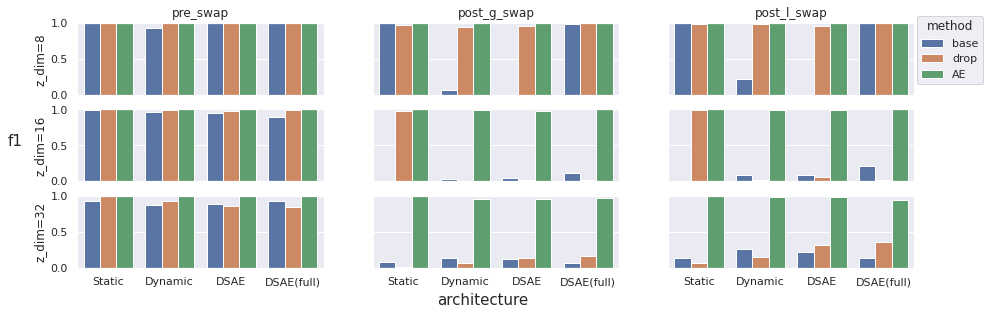

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

p_neg = 1 - sum(datamodule.train_dataset.label) / len((datamodule.train_dataset.label))
n_dim = len(set(df.z_dim))
metrics = ['pre_swap', 'post_g_swap', 'post_l_swap']
methods = ['Static', 'Dynamic', 'DSAE', 'DSAE(full)']
n_metric = len(metrics)

fig, ax = plt.subplots(n_dim, n_metric, figsize=(n_metric * 5, n_dim * 1.5), sharex=True, sharey=True)

for i, dim in enumerate(set(df.z_dim)):
    data = df[
        (df.z_dim == dim) & 
        (df.method != 'freeze') & 
        (df.method != 'freeze-drop') & 
        (df.method != 'prg') &
        (df.method != 'prg-drop')
    ]
    for j, met in enumerate(metrics):
        g = sns.barplot(
            data=data,
            x='arch', y=met, hue='method', order=methods,
            ax=ax[i][j]
        )
#         g.axhline(p_neg, color='k', linestyle='--', alpha=0.5)
#         g.axhline(1 - p_neg, color='k', linestyle='--', alpha=0.5)
        g.set_ylim([0, 1])
        g.get_legend().remove()
        g.set_xlabel("")
        g.set_ylabel("")
        if j % n_metric == 0:
            g.set_ylabel(f"z_dim={dim}", fontsize=12)
        if i == 0:
            g.set_title(f"{met}")

plt.legend(title="method", bbox_to_anchor=(1.01, 3.5), loc=2, borderaxespad=0., fancybox=True)


fig.text(0.5, 0.01, 'architecture', ha='center', fontsize=15)
fig.text(0.06, 0.5, 'f1', fontsize=15)

Text(0.06, 0.5, 'f1')

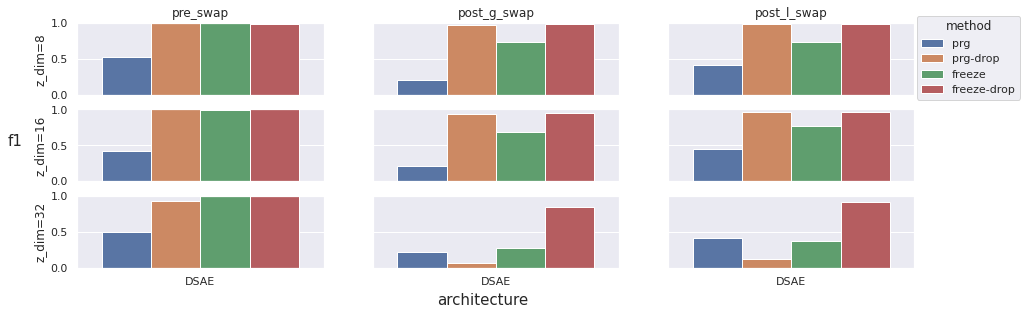

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

p_neg = 1 - sum(datamodule.train_dataset.label) / len((datamodule.train_dataset.label))
n_dim = len(set(df.z_dim))
metrics = ['pre_swap', 'post_g_swap', 'post_l_swap']
methods = ['DSAE']
n_metric = len(metrics)

fig, ax = plt.subplots(n_dim, n_metric, figsize=(n_metric * 5, n_dim * 1.5), sharex=True, sharey=True)

for i, dim in enumerate(set(df.z_dim)):
    data = df[
        (df.z_dim == dim) & 
        (df.method != 'AE') & 
        (df.method != 'drop') & 
        (df.method != 'base')
    ]
    for j, met in enumerate(metrics):
        g = sns.barplot(
            data=data,
            x='arch', y=met, hue='method', order=methods,
            ax=ax[i][j]
        )
#         g.axhline(p_neg, color='k', linestyle='--', alpha=0.5)
#         g.axhline(1 - p_neg, color='k', linestyle='--', alpha=0.5)
        g.set_ylim([0, 1])
        g.get_legend().remove()
        g.set_xlabel("")
        g.set_ylabel("")
        if j % n_metric == 0:
            g.set_ylabel(f"z_dim={dim}", fontsize=12)
        if i == 0:
            g.set_title(f"{met}")

plt.legend(title="method", bbox_to_anchor=(1.01, 3.5), loc=2, borderaxespad=0., fancybox=True)


fig.text(0.5, 0.01, 'architecture', ha='center', fontsize=15)
fig.text(0.06, 0.5, 'f1', fontsize=15)

In [478]:
data

path       run  data epoch  \
12  multirun/2021-11-13/11-17-18/0/wandb/run-20211...  2wfjj0g0  Urmp  2971   
13  multirun/2021-11-13/11-17-18/1/wandb/run-20211...  2uu9rue5  Urmp  2981   
14  multirun/2021-11-13/11-17-18/2/wandb/run-20211...  3ncg8o58  Urmp  2998   
15  multirun/2021-11-13/12-44-08/0/wandb/run-20211...  zvmxbhz2  Urmp  2984   
16  multirun/2021-11-13/12-44-08/1/wandb/run-20211...  2azb5dxh  Urmp  2983   
17  multirun/2021-11-13/12-44-08/2/wandb/run-20211...  3p5894yz  Urmp  2984   
21  multirun/2021-11-13/14-48-31/0/wandb/run-20211...  1wjq6vd2  Urmp  2984   
22  multirun/2021-11-13/14-48-31/1/wandb/run-20211...  2wzozzzf  Urmp  2990   
23  multirun/2021-11-13/14-48-31/2/wandb/run-20211...  2t3u76jl  Urmp  2999   
24  multirun/2021-11-13/14-56-09/0/wandb/run-20211...  3wyra1xi  Urmp  2964   
25  multirun/2021-11-13/14-56-09/1/wandb/run-20211...  1x1z8rbg  Urmp  2964   
26  multirun/2021-11-13/14-56-09/2/wandb/run-20211...  2b3pd1sa  Urmp  2991   
30  multirun/2021-11-13/15-17-41/0/wandb/run-20211...  1b1ilj2l  Urmp  2984   
31  multirun/2021-11-13/15-17-41/1/wandb/run-20211...  1a1lkf04  Urmp  2997   
32  multirun/2021-11-13/15-17-41/2/wandb/run-20211...  1l6lry1p  Urmp  2994   
36  multirun/2021-11-13/18-05-51/0/wandb/run-20211...  1pdjmura  Urmp  2924   
37  multirun/2021-11-13/18-05-51/1/wandb/run-20211...  1i61ax05  Urmp  2991   
38  multirun/2021-11-13/18-05-51/2/wandb/run-20211...  3dd60uig  Urmp  2996   
51  multirun/2021-11-13/23-34-32/0/wandb/run-20211...  o4a83u7l  Urmp  2911   
52  multirun/2021-11-13/23-34-32/1/wandb/run-20211...  2rzt9r8x  Urmp  2928   
53  multirun/2021-11-13/23-34-32/2/wandb/run-20211...  3nqbyx78  Urmp  2999   
54  multirun/2021-11-14/00-43-18/0/wandb/run-20211...  p5tp060q  Urmp  2986   
55  multirun/2021-11-14/00-43-18/1/wandb/run-20211...  1y77odjf  Urmp  2997   
56  multirun/2021-11-14/00-43-18/2/wandb/run-20211...  31df44mh  Urmp  2998   
62  multirun/2021-11-14/02-31-49/2/wandb/run-20211...  6znfc3wi  Urmp  2999   
63  multirun/2021-11-14/07-12-35/0/wandb/run-20211...  25sla3yw  Urmp  2983   
64  multirun/2021-11-14/07-12-35/1/wandb/run-20211...  lwsh63hm  Urmp  2971   
65  multirun/2021-11-14/07-12-35/2/wandb/run-20211...  1v3n5dx0  Urmp  2988   

    z_dim  progressive  drop_rate prior feature  content_condition  \
12      8         True        0.0     0       0              False   
13     16         True        0.0     0       0              False   
14     32         True        0.0     0       0              False   
15      8         True        0.0     2       0              False   
16     16         True        0.0     2       0              False   
17     32         True        0.0     2       0              False   
21      8         True        0.0     2       =              False   
22     16         True        0.0     2       =              False   
23     32         True        0.0     2       =              False   
24      8         True        0.2     0       0              False   
25     16         True        0.2     0       0              False   
26     32         True        0.2     0       0              False   
30      8         True        0.0     2       =               True   
31     16         True        0.0     2       =               True   
32     32         True        0.0     2       =               True   
36      8         True        0.2     2       0              False   
37     16         True        0.2     2       0              False   
38     32         True        0.2     2       0              False   
51      8         True        0.2     2       =              False   
52     16         True        0.2     2       =              False   
53     32         True        0.2     2       =              False   
54      8         True        0.2     2       =               True   
55     16         True        0.2     2       =               True   
56     32         True        0.2     2       =               True   
62     

In [492]:
disentangle_model = pd.concat([df[(df.method==i) & (df.arch=='DSA')] for i in ['ae', 'drop', 'prg-drop', 'freeze-drop']])

Text(0.5, 0.05, 'architecture')

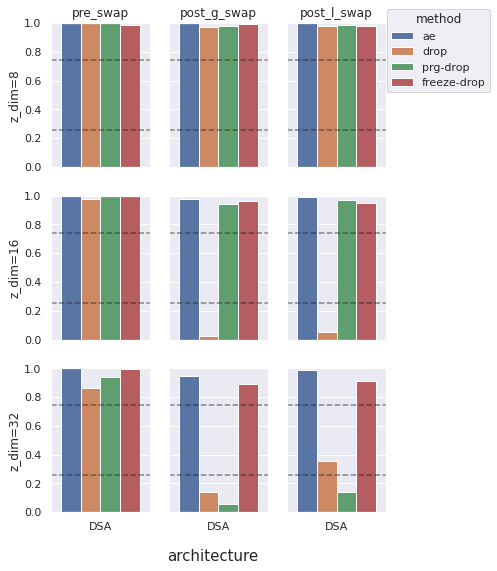

In [493]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

p_neg = 1 - sum(datamodule.train_dataset.label) / len((datamodule.train_dataset.label))
n_dim = len(set(df.z_dim))
metrics = ['pre_swap', 'post_g_swap', 'post_l_swap']
methods = ['DSA']
n_metric = len(metrics)

fig, ax = plt.subplots(n_dim, n_metric, figsize=(n_metric * 2, n_dim * 3), sharex=True, sharey=True)

for i, dim in enumerate(set(df.z_dim)):
    for j, met in enumerate(metrics):
        g = sns.barplot(
            data=disentangle_model[disentangle_model.z_dim==dim],
            x='arch', y=met, hue='method', order=methods,
            ax=ax[i][j]
        )
        g.axhline(p_neg, color='k', linestyle='--', alpha=0.5)
        g.axhline(1 - p_neg, color='k', linestyle='--', alpha=0.5)
        g.set_ylim([0, 1])
        g.get_legend().remove()
        g.set_xlabel("")
        g.set_ylabel("")
        if j % n_metric == 0:
            g.set_ylabel(f"z_dim={dim}", fontsize=12)
        if i == 0:
            g.set_title(f"{met}")

plt.legend(title="method", bbox_to_anchor=(1.01, 3.5), loc=2, borderaxespad=0., fancybox=True)

fig.text(0.5, 0.05, 'architecture', ha='center', fontsize=15)

Text(0.5, -0.1, 'architecture')

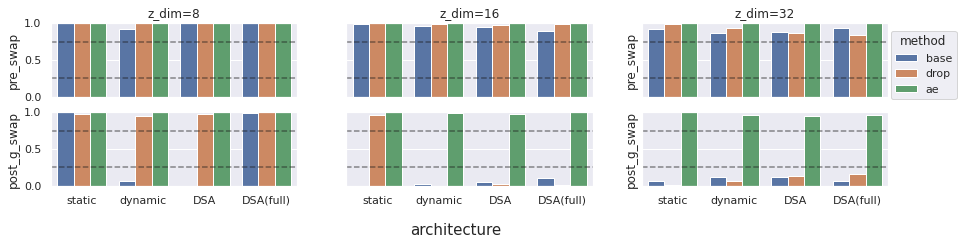

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

p_neg = 1 - sum(datamodule.train_dataset.label) / len((datamodule.train_dataset.label))
n_dim = len(set(df.z_dim))
metrics = ['pre_swap', 'post_g_swap']
methods = ['static', 'dynamic', 'DSA', 'DSA(full)']
n_metric = len(metrics)

fig, ax = plt.subplots(n_metric, n_dim, figsize=(n_dim * 5, n_metric * 1.5), sharex=True, sharey=True)

for i, met in enumerate(metrics):
    for j, dim in enumerate(set(df.z_dim)):
        data = df[
        (df.z_dim == dim) & 
        (df.method != 'freeze') & 
        (df.method != 'freeze-drop') & 
        (df.method != 'prg') &
        (df.method != 'prg-drop')]
        g = sns.barplot(
            data=data,
            x='arch', y=met, hue='method', order=methods,
            ax=ax[i][j]
        )
        g.axhline(p_neg, color='k', linestyle='--', alpha=0.5)
        g.axhline(1 - p_neg, color='k', linestyle='--', alpha=0.5)
        g.set_ylim([0, 1])
        g.get_legend().remove()
        g.set_xlabel("")
        g.set_ylabel("")
        if j % n_metric == 0:
            g.set_ylabel(f"{met}", fontsize=12)
        if i == 0:
            g.set_title(f"z_dim={dim}")

plt.legend(title="method", bbox_to_anchor=(1.01, 2.1), loc=2, borderaxespad=0., fancybox=True)


fig.text(0.5, -0.1, 'architecture', ha='center', fontsize=15)


Text(0.5, -0.1, 'architecture')

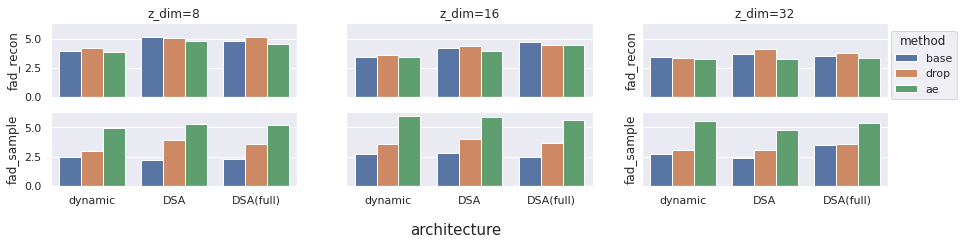

In [448]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

n_dim = len(set(df.z_dim))
metrics = ['fad_recon', 'fad_sample']
methods = ['dynamic', 'DSA', 'DSA(full)']
n_metric = len(metrics)

fig, ax = plt.subplots(n_metric, n_dim, figsize=(n_dim * 5, n_metric * 1.5), sharex=True, sharey=True)

for i, met in enumerate(metrics):
    for j, dim in enumerate(set(df.z_dim)):
        data = df[
        (df.z_dim == dim) & 
        (df.method != 'freeze') & 
        (df.method != 'freeze-drop') & 
        (df.method != 'prg') &
        (df.method != 'prg-drop')]
        g = sns.barplot(
            data=data,
            x='arch', y=met, hue='method', order=methods,
            ax=ax[i][j]
        )
        g.get_legend().remove()
        g.set_xlabel("")
        g.set_ylabel("")
        if j % n_metric == 0:
            g.set_ylabel(f"{met}", fontsize=12)
        if i == 0:
            g.set_title(f"z_dim={dim}")

plt.legend(title="method", bbox_to_anchor=(1.01, 2.1), loc=2, borderaxespad=0., fancybox=True)


fig.text(0.5, -0.1, 'architecture', ha='center', fontsize=15)

Text(0.5, 0.01, 'architecture')

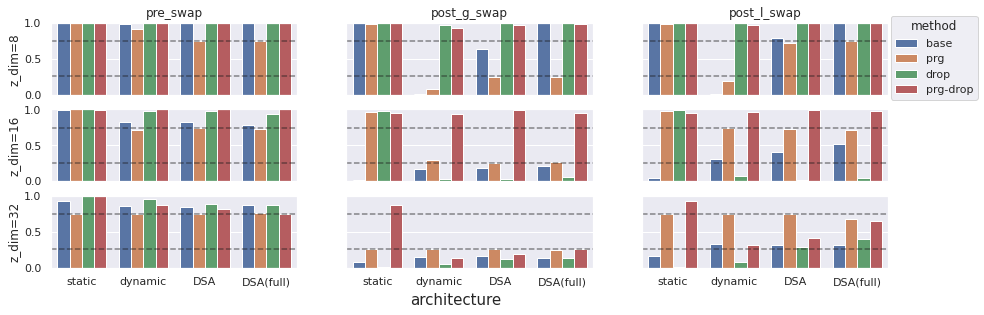

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

p_neg = 1 - sum(datamodule.train_dataset.label) / len((datamodule.train_dataset.label))
n_dim = len(set(df.z_dim))
metrics = ['pre_swap', 'post_g_swap', 'post_l_swap']
methods = ['static', 'dynamic', 'DSA', 'DSA(full)']
n_metric = len(metrics)

fig, ax = plt.subplots(n_dim, n_metric, figsize=(n_metric * 5, n_dim * 1.5), sharex=True, sharey=True)

for i, dim in enumerate(set(df.z_dim)):
    data = df[(df.z_dim == dim)]
    for j, met in enumerate(metrics):
        g = sns.barplot(
            data=data,
            x='arch', y=met, hue='method', order=methods,
            ax=ax[i][j]
        )
        g.axhline(p_neg, color='k', linestyle='--', alpha=0.5)
        g.axhline(1 - p_neg, color='k', linestyle='--', alpha=0.5)
        g.set_ylim([0, 1])
        g.get_legend().remove()
        g.set_xlabel("")
        g.set_ylabel("")
        if j % n_metric == 0:
            g.set_ylabel(f"z_dim={dim}", fontsize=12)
        if i == 0:
            g.set_title(f"{met}")

plt.legend(title="method", bbox_to_anchor=(1.01, 3.5), loc=2, borderaxespad=0., fancybox=True)


fig.text(0.5, 0.01, 'architecture', ha='center', fontsize=15)


Text(0.5, 0.01, 'architecture')

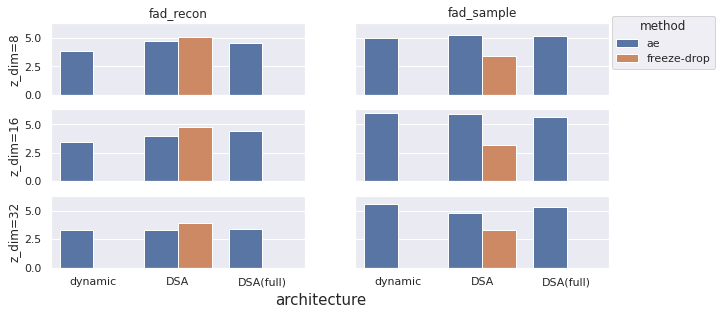

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

p_neg = 1 - sum(datamodule.train_dataset.label) / len((datamodule.train_dataset.label))
n_dim = len(set(df.z_dim))
metrics = ['fad_recon', 'fad_sample']
methods = ['dynamic', 'DSA', 'DSA(full)']
n_metric = len(metrics)

fig, ax = plt.subplots(n_dim, n_metric, figsize=(n_metric * 5, n_dim * 1.5), sharex=True, sharey=True)

for i, dim in enumerate(set(df.z_dim)):
    data = df[
        (df.z_dim == dim) & 
        (df.method != 'base') & 
        (df.method != 'freeze') & 
        (df.method != 'prg') &
        (df.method != 'prg-drop') & 
        (df.method != 'drop')
        # (df.method != 'ae') &
        # (df.method != 'freeze-drop') & 
    ]
    for j, met in enumerate(metrics):
        g = sns.barplot(
            data=data,
            x='arch', y=met, hue='method', order=methods,
            ax=ax[i][j]
        )
        g.get_legend().remove()
        g.set_xlabel("")
        g.set_ylabel("")
        if j % n_metric == 0:
            g.set_ylabel(f"z_dim={dim}", fontsize=12)
        if i == 0:
            g.set_title(f"{met}")

plt.legend(title="method", bbox_to_anchor=(1.01, 3.5), loc=2, borderaxespad=0., fancybox=True)


fig.text(0.5, 0.01, 'architecture', ha='center', fontsize=15)


# Summary of the barplots
## Observation
The dashed lines denote the prior of LDA based on numbers of class samples, So the upper one is the percentage of the dominating class in the dataset -- an uninformative global latent space can attain this level of accuracy.
- `pre_swap` (whether the global encoder learns a discriminative latent space)
    - `z_dim` and model expressivity affect discriminability of the global latent space.
    - The method `drop` is better than `prg` in terms of preventing posterior collapse (phenomenon that causes an uninformative global latent).
- `post_g_swap` (whether the decoder is responsive to change of the global latent)
    - A discriminative, non-collapsed global latent does not mean a responsive decoder.
    - The local dynamic is not necessarily beneficial.
    - With a small size of the local latent, the extra condition, DSA(full), improves.
    - `z_dim` and model expressivity again dominate the effect.
    - In most cases, progressive training and dropout should both be applied (`prg-drop`) to maintain the performance.
- `post_l_swap` (whether the local latent carries the global information)
    - Those with 0% accuracy imply that their `pre_swap` is high (discriminative global) while `post_g_swap` is low (decoder is independent of global latent), and all the information is captured in the local latent.

## Summary
- What's the minimally viable model for disentanglement?
    - The simplest static model -- the inductive bias of the distinct temporal resolution between the two latents is sufficient for the disentanglement.
- What are the critical parameters that cause posterior collapse of the global latent variable?
    - `z_dim` and model expressivity -- the temporal dynamic is unnecessary and can be harmful.
- What are the techniques that prevent it?
    - Dropout appears to be a surprior measure over progressive training. With a large local latent and an expressive model, both measures are required.


Text(0.5, 0.01, 'architecture')

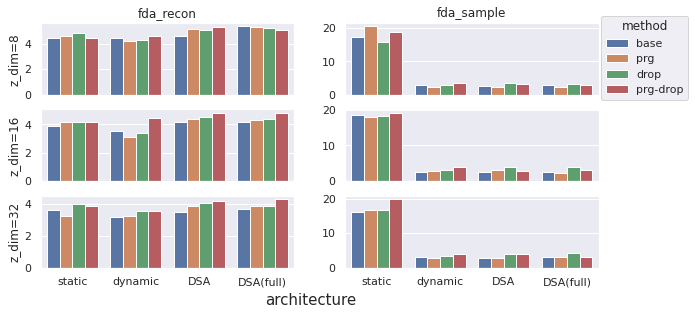

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

p_neg = 1 - sum(datamodule.train_dataset.label) / len((datamodule.train_dataset.label))
n_dim = len(set(df.z_dim))
metrics = ['fda_recon', 'fda_sample']
methods = ['static', 'dynamic', 'DSA', 'DSA(full)']
n_metric = len(metrics)

fig, ax = plt.subplots(n_dim, n_metric, figsize=(n_metric * 5, n_dim * 1.5), sharex=True, sharey=False)

for i, dim in enumerate(set(df.z_dim)):
    data = df[(df.z_dim == dim)]
    for j, met in enumerate(metrics):
        g = sns.barplot(
            data=data,
            x='arch', y=met, hue='method', order=methods,
            ax=ax[i][j]
        )
        g.get_legend().remove()
        g.set_xlabel("")
        g.set_ylabel("")
        if j % n_metric == 0:
            g.set_ylabel(f"z_dim={dim}", fontsize=12)
        if i == 0:
            g.set_title(f"{met}")

plt.legend(title="method", bbox_to_anchor=(1.01, 3.5), loc=2, borderaxespad=0., fancybox=True)


fig.text(0.5, 0.01, 'architecture', ha='center', fontsize=15)


In [30]:
data

path       run  data epoch  \
0   multirun/2021-10-31/04-29-54/0/wandb/run-20211...  3u8a66e0  Urmp  1999   
3   multirun/2021-10-31/04-30-39/0/wandb/run-20211...  13npbb2h  Urmp  1998   
6   multirun/2021-10-31/09-21-38/0/wandb/run-20211...  l9l64wtf  Urmp  1989   
9   multirun/2021-10-31/09-47-21/0/wandb/run-20211...  3bue886x  Urmp  1993   
12  multirun/2021-10-31/13-58-19/0/wandb/run-20211...  3qp21nns  Urmp  1997   
15  multirun/2021-10-31/14-54-41/0/wandb/run-20211...  1woggxqt  Urmp  1969   
18  multirun/2021-10-31/18-50-14/0/wandb/run-20211...  3ky7g760  Urmp  1982   
21  multirun/2021-10-31/20-23-54/0/wandb/run-20211...  1x3ksmm2  Urmp  1958   
24  multirun/2021-11-01/04-56-59/0/wandb/run-20211...  2f2xyltx  Urmp  1999   
27  multirun/2021-11-01/07-23-59/0/wandb/run-20211...  yp4lpoki  Urmp  1992   
30  multirun/2021-11-01/11-36-49/0/wandb/run-20211...  r999wqne  Urmp  1993   
33  multirun/2021-11-01/13-59-04/0/wandb/run-20211...  kry7onxo  Urmp  1999   
36  multirun/2021-11-01/18-22-01/0/wandb/run-20211...  22rrydyh  Urmp  1992   
39  multirun/2021-11-01/20-39-53/0/wandb/run-20211...  29o56lnu  Urmp  1978   
42  multirun/2021-11-02/01-03-32/0/wandb/run-20211...  1q7xsblb  Urmp  1991   
45  multirun/2021-11-02/03-16-53/0/wandb/run-20211...  j4xx8qbf  Urmp  1974   

    z_dim  progressive  drop_rate prior feature  content_condition  pre_swap  \
0       8        False        0.0     2       0              False  0.988462   
3       8        False        0.0     0       0              False  1.000000   
6       8         True        0.0     0       0              False  0.992308   
9       8         True        0.0     2       0              False  0.915385   
12      8        False        0.2     0       0              False  1.000000   
15      8        False        0.2     2       0              False  1.000000   
18      8         True        0.2     0       0              False  1.000000   
21      8         True        0.2     2       0              False  1.000000   
24      8        False        0.0     2       =              False  1.000000   
27      8        False        0.0     2       =               True  1.000000   
30      8         True        0.0     2       =              False  0.746154   
33      8         True        0.0     2       =               True  0.746154   
36      8        False        0.2     2       =              False  1.000000   
39      8        False        0.2     2       =               True  1.000000   
42      8         True        0.2     2       =              False  1.000000   
45      8         True        0.2     2       =               True  1.000000   

    post_g_swap  post_l_swap  fda_recon  fda_sample       arch    method  
0      0.011538     0.011538   4.409715    2.933083    dynamic      base  
3      1.000000     1.000000   4.408749   17.113041     static      base  
6      0.980769     0.984615   4.564784   20.384184     static       prg  
9      0.084615     0.192308   4.171708    2.411811    dynamic       prg  
12     1.000000     1.000000   4.852933   15.660465     static      drop  
15     0.973077     1.000000   4.251221    3.006960    dynamic      drop  
18     0.992308     0.992308   4.398495   18.797389     static  prg-drop  
21     0.926923     0.976923   4.613910    3.487676    dynamic  prg-drop  
24     0.630769     0.796154   4.626017    2.491925        DSA      base  
27     0.992308     0.996154   5.341031    2.963619  DSA(full)      base  
30     0.253846     0.726923   5.141492    2.451458        DSA       prg  
33     0.253846     0.742308   5.266884    2.381729  DSA(full)       prg  
36     1.000000     1.000000   5.040822    3.532401        DSA      drop  
39     0.996154     0.996154   5.226237    3.270665  DSA(full)      drop  
42     0.965385     0.992308   5.315388    3.105424        DSA  prg-drop  
45     0.980769     0.992308   5.089099    2.989997  DSA(full)  prg-drop

In [29]:
list(data[data.arch=='DSA(full)'].path)[3]

'multirun/2021-11-02/03-16-53/0/wandb/run-20211102_031659-j4xx8qbf/files/dvae/j4xx8qbf/checkpoints/epoch=1974-step=33574.ckpt'

Text(0.5, 0.01, 'architecture')

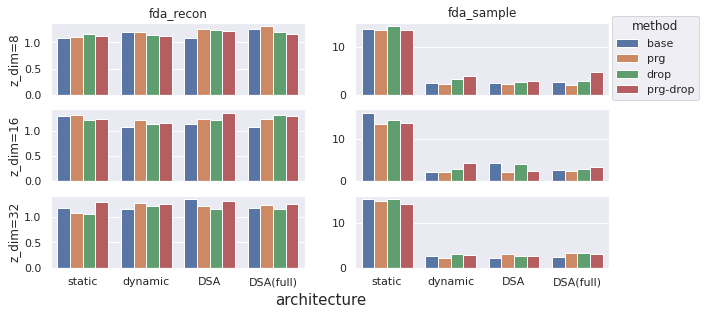

In [264]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

p_neg = 1 - sum(datamodule.train_dataset.label) / len((datamodule.train_dataset.label))
n_dim = len(set(df.z_dim))
metrics = ['fda_recon', 'fda_sample']
methods = ['static', 'dynamic', 'DSA', 'DSA(full)']
n_metric = len(metrics)

fig, ax = plt.subplots(n_dim, n_metric, figsize=(n_metric * 5, n_dim * 1.5), sharex=True, sharey=False)

for i, dim in enumerate(set(df.z_dim)):
    data = df[(df.z_dim == dim)]
    for j, met in enumerate(metrics):
        g = sns.barplot(
            data=data,
            x='arch', y=met, hue='method', order=methods,
            ax=ax[i][j]
        )
        g.get_legend().remove()
        g.set_xlabel("")
        g.set_ylabel("")
        if j % n_metric == 0:
            g.set_ylabel(f"z_dim={dim}", fontsize=12)
        if i == 0:
            g.set_title(f"{met}")

plt.legend(title="method", bbox_to_anchor=(1.01, 3.5), loc=2, borderaxespad=0., fancybox=True)


fig.text(0.5, 0.01, 'architecture', ha='center', fontsize=15)


In [10]:
df.to_csv('results/run_urmp_sampleFDA.csv')
df.to_pickle('results/run_urmp_sampleFDA.pkl')

In [13]:
df.to_csv('results/run_urmp.csv')
df.to_pickle('results/run_urmp.pkl')

In [14]:
df

data epoch  z_dim  progressive  drop_rate  pre_swap  post_g_swap  \
0   Urmp  1999      8        False        0.0  1.000000     0.000000   
1   Urmp  1992     16        False        0.0  0.853846     0.146154   
2   Urmp  1984     32        False        0.0  0.838462     0.161538   
3   Urmp  1998      8         True        0.0  0.734615     0.265385   
4   Urmp  1998     16         True        0.0  0.746154     0.253846   
5   Urmp  1983     32         True        0.0  0.742308     0.257692   
6   Urmp  1989      8        False        0.2  1.000000     1.000000   
7   Urmp  1993     16        False        0.2  0.973077     0.026923   
8   Urmp  1996     32        False        0.2  0.915385     0.084615   
9   Urmp  1991      8         True        0.2  1.000000     0.957692   
10  Urmp  1999     16         True        0.2  1.000000     0.965385   
11  Urmp  1999     32         True        0.2  0.815385     0.184615   

    post_l_swap  fda_recon  fda_sample  
0      0.000000   0.089580    2.050223  
1      0.315385   0.091510    2.660694  
2      0.323077   0.093653    1.950735  
3      0.746154   0.101714    2.279695  
4      0.730769   0.087066    1.913649  
5      0.742308   0.093809    2.791020  
6      1.000000   0.102941    3.372593  
7      0.069231   0.097985    3.437747  
8      0.157692   0.087457    3.141849  
9      0.984615   0.098440    2.990451  
10     0.988462   0.098472    2.671321  
11     0.384615   0.100980    3.183418

In [12]:
import numpy as np
import tensorflow as tf

In [13]:
tf_record_0 = list(tf.compat.v1.python_io.tf_record_iterator('0-ref_embedding'))
tf_record_1 = list(tf.compat.v1.python_io.tf_record_iterator('1-ref_embedding'))
# example = tf.train.Example().FromString(tf_record)
# x = np.array(example.features.feature['embedding'].float_list.value)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [14]:
x_0 = np.vstack(list(map(lambda x: np.array(tf.train.Example().FromString(x).features.feature['embedding'].float_list.value), tf_record_0)))
x_1 = np.vstack(list(map(lambda x: np.array(tf.train.Example().FromString(x).features.feature['embedding'].float_list.value), tf_record_1)))
y = np.hstack([np.zeros(len(x_0)), np.ones(len(x_1))])

In [15]:
x = np.vstack([x_0, x_1])

In [14]:
y_0 = np.split(x_0, int(x_0.shape[0] / 7)) 
y_1 = np.split(x_1, int(x_1.shape[0] / 7))

In [23]:
z_0 = np.vstack(list(map(lambda x: x.mean(axis=0), y_0)))

In [17]:
from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as TSNE

In [23]:
pca = PCA(2)
x_emb = pca.fit_transform(x)
x_emb = TSNE().fit_transform(x)

In [19]:
import matplotlib.pyplot as plt

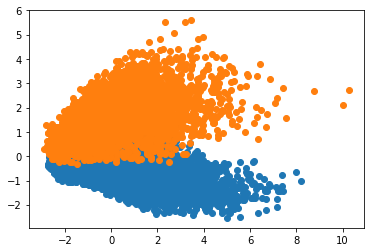

In [21]:
fig, ax = plt.subplots(1,1)
for i in np.unique(y):
    d = x_emb[y == i]
    ax.scatter(d[:,0], d[:,1])

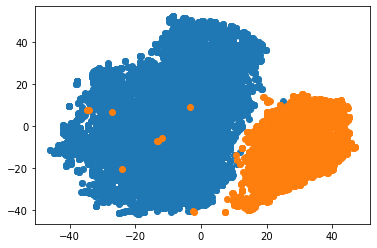

In [24]:
fig, ax = plt.subplots(1,1)
for i in np.unique(y):
    d = x_emb[y == i]
    ax.scatter(d[:,0], d[:,1])

In [ ]:
model.eval()

In [ ]:
datamodule.setup()
train_dl = datamodule.train_dataloader()
val_dl = datamodule.val_dataloader()

In [ ]:
import torch
from src.metric import LdaClassifier, NearestNeighbor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

In [ ]:
for i, batch in enumerate(train_dl):
    input, input_reversed, mask, seq_lengths, labels = batch
    if i == 0:
        input_stack = input
        input_reversed_stack = input_reversed
        mask_stack = mask
        seq_lengths_stack = seq_lengths
        labels_stack = labels
    else:
        input_stack = torch.vstack([input_stack, input])
        input_reversed_stack = torch.vstack([input_reversed_stack, input_reversed])        
        mask_stack = torch.vstack([mask_stack, mask])
        seq_lengths_stack = torch.hstack([seq_lengths_stack, seq_lengths])
        labels_stack = torch.vstack([labels_stack, labels])
        
outputs = model.forward(input_stack, input_reversed_stack, seq_lengths_stack, mask_stack)

In [13]:
lda = LinearDiscriminantAnalysis()
lda.fit(outputs['content_mean'].detach().numpy(), labels_stack.detach().numpy()[:,0])

LinearDiscriminantAnalysis()

In [14]:
for i, batch in enumerate(val_dl):
    input, input_reversed, mask, seq_lengths, labels = batch
    if i == 0:
        input_stack = input
        input_reversed_stack = input_reversed
        mask_stack = mask
        seq_lengths_stack = seq_lengths
        labels_stack = labels
    else:
        input_stack = torch.vstack([input_stack, input])
        input_reversed_stack = torch.vstack([input_reversed_stack, input_reversed])        
        mask_stack = torch.vstack([mask_stack, mask])
        seq_lengths_stack = torch.hstack([seq_lengths_stack, seq_lengths])
        labels_stack = torch.vstack([labels_stack, labels])
        
outputs = model.forward(input_stack, input_reversed_stack, seq_lengths_stack, mask_stack)

In [15]:
source_content, _, _, _, _, _ = model.infer_content(outputs['reconstruction'], seq_lengths=seq_lengths_stack, mask=mask_stack)

In [57]:
paired_idx.size()

torch.Size([260, 1])

In [60]:
chosen.size()

torch.Size([1])

In [61]:
chosen.squeeze()

tensor(135)

In [71]:
paired_idx = torch.empty_like(labels_stack)
for n, i in enumerate(labels_stack):
    candidate_idx = torch.where(labels_stack != i)[0]
    chosen = torch.multinomial(torch.ones_like(candidate_idx, dtype=float), 1)
    paired_idx[n] = candidate_idx[chosen]
assert sum(labels_stack[paired_idx.squeeze(-1)] != labels_stack) == len(labels_stack)

In [80]:
sampled_idx = torch.empty_like(labels_stack)
for i, y in enumerate(labels_stack):
    paired_candidates = torch.nonzero(labels_stack != y)
    prob_vector = torch.ones(len(paired_candidates))
    sampled_idx[i] = torch.multinomial(prob_vector, 1)
assert sum(labels_stack[sampled_idx.squeeze(-1)] != labels_stack) == len(labels_stack)

AssertionError: 

In [35]:
mask_stack[paired_idx]

IndexError: index 140138401194352 is out of bounds for dimension 0 with size 260

In [16]:
dict_data = {
    'pre_swap': source_content, labels_stack,
    'post_c_swap':,
    'post_z_swap':,
}

SyntaxError: invalid syntax (4162976037.py, line 2)

In [118]:
source_idx = torch.where(labels_stack == 0)[0][0]
target_idx = torch.where(labels_stack == 1)[0][0]
source_content_mean = outputs['content_mean'][source_idx].unsqueeze(0)
target_content_mean = outputs['content_mean'][target_idx].unsqueeze(0)
source_local = outputs['posterior'][source_idx].unsqueeze(0)

In [119]:
x_source = model.decode(source_local, source_content_mean.repeat(1, source_local.size(1), 1))
x_target = model.decode(source_local, target_content_mean.repeat(1, source_local.size(1), 1))

In [120]:
source_content, _, _, _, _, _ = model.infer_content(x_source, seq_lengths=seq_lengths_stack[source_idx].unsqueeze(0), mask=mask_stack[source_idx].unsqueeze(0))
target_content, _, _, _, _, _ = model.infer_content(x_target, seq_lengths=seq_lengths_stack[source_idx].unsqueeze(0), mask=mask_stack[source_idx].unsqueeze(0))

In [121]:
lda = LinearDiscriminantAnalysis()
lda.fit(outputs['content_mean'].detach().numpy(), labels_stack.detach().numpy()[:,0])
# print(lda.predict(source_content_mean.detach().numpy()))
# print(lda.predict(target_content_mean.detach().numpy()))
# print(lda.predict(source_content.detach().numpy()))
# print(lda.predict(target_content.detach().numpy()))

LinearDiscriminantAnalysis()

In [122]:
for i, batch in enumerate(val_dl):
    input, input_reversed, mask, seq_lengths, labels = batch
    if i == 0:
        input_stack = input
        input_reversed_stack = input_reversed
        mask_stack = mask
        seq_lengths_stack = seq_lengths
        labels_stack = labels
    else:
        input_stack = torch.vstack([input_stack, input])
        input_reversed_stack = torch.vstack([input_reversed_stack, input_reversed])        
        mask_stack = torch.vstack([mask_stack, mask])
        seq_lengths_stack = torch.hstack([seq_lengths_stack, seq_lengths])
        labels_stack = torch.vstack([labels_stack, labels])
        
outputs = model.forward(input_stack, input_reversed_stack, seq_lengths_stack, mask_stack)

In [124]:
lda.score(outputs['content_mean'].detach().numpy(), labels_stack.detach().numpy()[:,0])

0.95

In [128]:
source_content, _, _, _, _, _ = model.infer_content(outputs['reconstruction'], seq_lengths=seq_lengths_stack, mask=mask_stack)

In [131]:
lda.score(source_content.detach().numpy(), labels_stack.detach().numpy()[:,0])

0.9730769230769231

In [142]:
source_idx = torch.where(labels_stack == 0)[0][5]
target_idx = torch.where(labels_stack == 1)[0][15]
source_content_mean = outputs['content_mean'][source_idx].unsqueeze(0)
target_content_mean = outputs['content_mean'][target_idx].unsqueeze(0)
source_local = outputs['posterior'][source_idx].unsqueeze(0)
x_source = model.decode(source_local, source_content_mean.repeat(1, source_local.size(1), 1))
x_target = model.decode(source_local, target_content_mean.repeat(1, source_local.size(1), 1))
source_content, _, _, _, _, _ = model.infer_content(x_source, seq_lengths=seq_lengths_stack[source_idx].unsqueeze(0), mask=mask_stack[source_idx].unsqueeze(0))
target_content, _, _, _, _, _ = model.infer_content(x_target, seq_lengths=seq_lengths_stack[source_idx].unsqueeze(0), mask=mask_stack[source_idx].unsqueeze(0))
print(lda.predict(source_content_mean.detach().numpy()))
print(lda.predict(target_content_mean.detach().numpy()))
print(lda.predict(source_content.detach().numpy()))
print(lda.predict(target_content.detach().numpy()))

[0]
[1]
[0]
[0]


In [77]:
import numpy as np

In [78]:
x1 = outputs['content_mean'].detach().cpu().numpy()[np.where([labels_stack[:,-1].detach().cpu().numpy() == 1])[0]]

In [79]:
x2 = outputs['content_mean'].detach().cpu().numpy()[np.where([labels_stack[:,-1].detach().cpu().numpy() == 0])[0]]

In [99]:
lda = LinearDiscriminantAnalysis()
# lda.fit(outputs['content_mean'].detach().cpu().numpy(), labels_stack[:,-1].detach().cpu().numpy())
emb = lda.fit_transform(outputs['content_mean'].detach().cpu().numpy(), labels_stack[:,-1].detach().cpu().numpy())
x1 = emb[np.where(labels_stack[:,-1].detach().cpu().numpy()==0)[0]]
x2 = emb[np.where(labels_stack[:,-1].detach().cpu().numpy()==1)[0]]

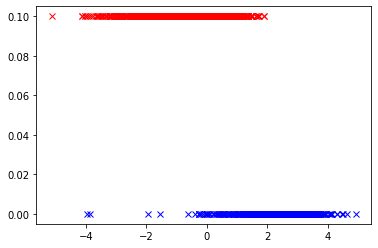

In [83]:
plt.plot(x1, np.zeros_like(x1) + 0.1, 'x', c='r')
plt.plot(x2, np.zeros_like(x2), 'x', c='b')

In [98]:
sum((x1 > 0))

array([306])

In [106]:
lda = LinearDiscriminantAnalysis()
lda.fit(emb, labels_stack[:,-1].detach().cpu().numpy())
lda.score(emb, labels_stack[:,-1].detach().cpu().numpy())

0.948051948051948

In [114]:
lda.

array([1.])

In [39]:
lda.predict(outputs['content_mean'].detach().cpu().numpy())

array([0, 1, 0, ..., 1, 0, 0])

In [34]:
lda.predict(outputs['content_mean'].detach().cpu().numpy())

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1])

In [13]:
_, _, pre_swap_content, _, _, _ = model.infer_content(outputs['reconstruction'], deterministic=True, seq_lengths=seq_lengths_stack, mask=mask_stack)

In [14]:
score_original = lda(outputs['content_mean'].detach().cpu().numpy(), labels_stack[:,-1].detach().cpu().numpy())
score_recon = lda(pre_swap_content.detach().cpu().numpy(), labels_stack[:,-1].detach().cpu().numpy())

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

In [41]:
pca = PCA()
orgin_emb = pca.fit_transform(outputs['content_mean'].detach().cpu().numpy())

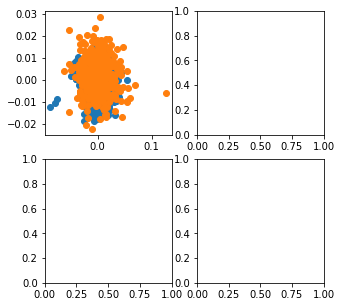

In [42]:
fig, ax = plt.subplots(2, 2, figsize=(5,5))
insts = labels_stack[:,-1].detach().cpu().numpy()
for l in np.unique(insts):
    idx = np.where(insts == l)
    x = orgin_emb[idx]
    ax[0][0].scatter(x[:, 0], x[:, 1], label=l)

In [32]:
labels_stack[:,-1].detach().cpu().numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [31]:
lda.predict(outputs['content_mean'].detach().cpu().numpy())

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1])

In [11]:
input, input_reversed, mask, seq_lengths, labels = next(iter(val_dl))

In [12]:
outputs = model.forward(input, input_reversed, seq_lengths, mask)

In [13]:
outputs.keys()

dict_keys(['reconstruction', 'input', 'posterior', 'prior', 'content', 'posterior_mean', 'prior_mean', 'content_mean', 'posterior_logvar', 'prior_logvar', 'content_logvar'])

In [51]:
import torch
from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as TSNE
import matplotlib.pyplot as plt
import numpy as np

In [15]:
mean_tsne = TSNE().fit_transform(outputs['content_mean'].detach().numpy())
mean_pca = PCA(n_components=2).fit_transform(outputs['content_mean'].detach().numpy())

sample_tsne = TSNE().fit_transform(outputs['content'].detach().numpy())
sample_pca = PCA(n_components=2).fit_transform(outputs['content'].detach().numpy())

# TSNE and PCA 2D projection of q(v|x)

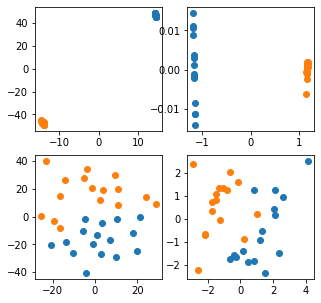

In [48]:
fig, ax = plt.subplots(2, 2, figsize=(5,5))
insts = labels[:,-1]
for l in np.unique(insts):
    idx = np.where(insts == l)
    x = mean_tsne[idx]
    ax[0][0].scatter(x[:, 0], x[:, 1], label=l)
    x = mean_pca[idx]
    ax[0][1].scatter(x[:, 0], x[:, 1], label=l)
    x = sample_tsne[idx]
    ax[1][0].scatter(x[:, 0], x[:, 1], label=l)
    x = sample_pca[idx]
    ax[1][1].scatter(x[:, 0], x[:, 1], label=l)

# Principal components

The first princpal component explains 99.997% of the variance.


Text(0.5, 1.0, 'Dimension importance of the first principal component')

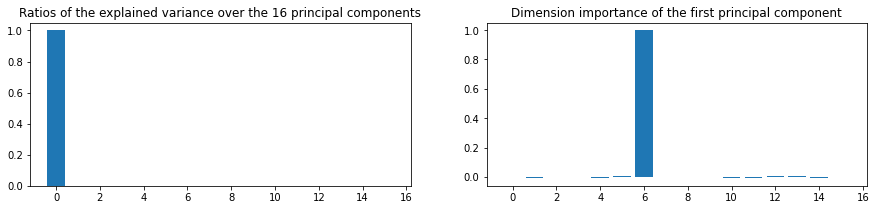

In [61]:
plt.close()
pca_content_mean = PCA().fit(outputs['content_mean'].detach().numpy())
var_ratio = pca_content_mean.explained_variance_ratio_
print(f"The first princpal component explains {(var_ratio[0] * 100):.3f}% of the variance.")
first_component = pca_content_mean.components_[0]

fig, ax = plt.subplots(1, 2, figsize=(5 * 3, 1 * 3))
ax[0].bar(np.arange(len(var_ratio)), var_ratio)
ax[0].set_title(f'Ratios of the explained variance over the {len(var_ratio)} principal components')
ax[1].bar(np.arange(len(var_ratio)), first_component)
ax[1].set_title('Dimension importance of the first principal component')

# Standard deviation of q(v|x)

In [144]:
torch.abs(outputs['content_mean']).mean(dim=0)

tensor([0.0080, 0.0090, 0.0118, 0.0033, 0.0055, 0.0099, 1.1693, 0.0092, 0.0064,
        0.0096, 0.0101, 0.0116, 0.0122, 0.0050, 0.0075, 0.0065],
       grad_fn=<MeanBackward1>)

Text(0.5, 1.0, 'Averaged absolute mean of posterior q(v|x)')

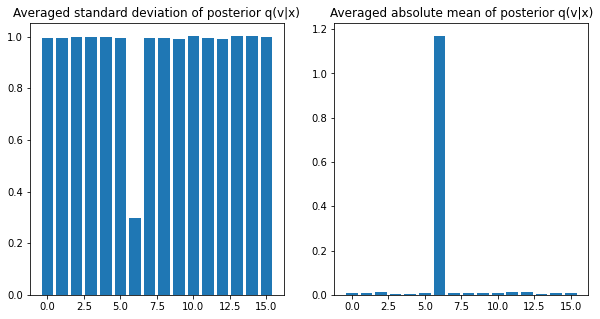

In [147]:
plt.close()
fig, ax = plt.subplots(1, 2, figsize=(2 * 5, 1*5))
var_mean = torch.exp(0.5 * outputs['content_logvar']).mean(dim=0)
var_var = torch.exp(0.5 * outputs['content_logvar']).var(dim=0)
ax[0].bar(np.arange(len(var_mean)), var_mean.detach().numpy())
ax[0].set_title("Averaged standard deviation of posterior q(v|x)")

ax[1].bar(
    np.arange(len(var_mean)), 
    torch.abs(outputs['content_mean']).mean(dim=0).detach().numpy()
)
ax[1].set_title("Averaged absolute mean of posterior q(v|x)")

In [70]:
content_std = torch.exp(0.5 * outputs['content_logvar'])

In [108]:
kl = torch.log(1 / content_std) + \
    (content_std ** 2 + outputs['content_mean'] ** 2) / (2 * 1 ** 2) - 0.5

# KLD[q(v|x) || p(v)]

Averaged KLD over dimension: 0.09


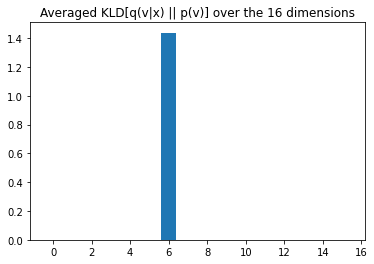

In [123]:
plt.close()
plt.bar(np.arange(kl.shape[1]), kl.mean(dim=0).detach().numpy())
plt.title(f"Averaged KLD[q(v|x) || p(v)] over the {kl.shape[1]} dimensions")
print(f"Averaged KLD over dimension: {(kl.mean().item()):.2f}")

In [18]:
# n_sample = 10
# idx = np.random.choice(len(outputs['posterior_mean']), size=n_sample, replace=False)
# mean_recon = model.decode(outputs['posterior'], outputs['content_mean'])[idx].detach().numpy()
# sample_recon = model.decode(outputs['posterior'], outputs['content'])[idx].detach().numpy()
# input = outputs['input'][idx]

In [124]:
# fig, ax = plt.subplots(3, n_sample, figsize=(n_sample * 5, 3 * 5))
# for n, i in enumerate(range(n_sample)):
#     ax[0][i].imshow(input[n].T, aspect='auto', origin='lower')
#     ax[1][i].imshow(mean_recon[n].T, aspect='auto', origin='lower')    
#     ax[2][i].imshow(sample_recon[n].T, aspect='auto', origin='lower')        

# Latent traversal along the 16 dimensions

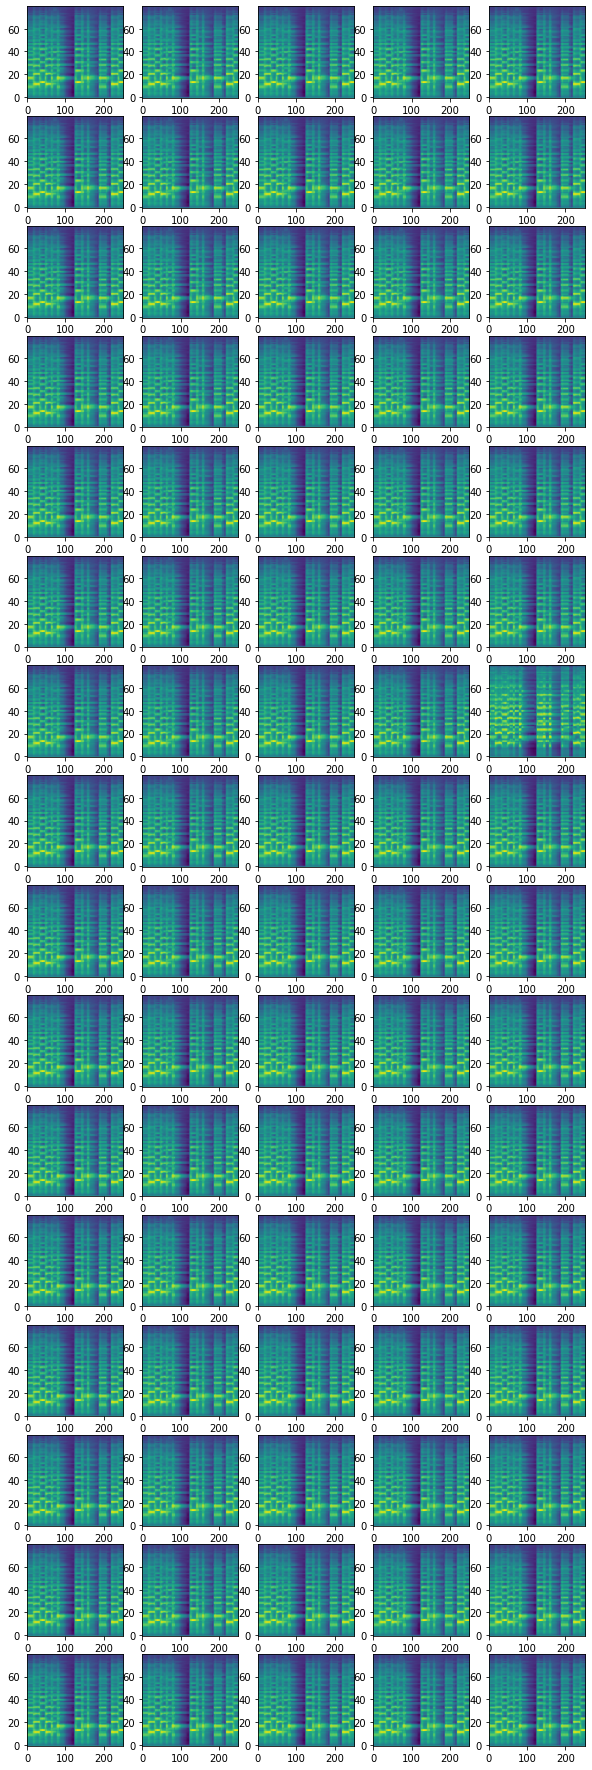

In [134]:
sample_idx = np.random.choice(np.arange(len(outputs['posterior_mean'])), size=1)[0]
origin = model.decode(outputs['posterior'], outputs['content_mean'])[sample_idx].detach().numpy().T

n_traverse = 5
traverse_std_bound = 5
fig, ax = plt.subplots(model.c_dim, n_traverse, figsize=(n_traverse * 2, model.c_dim * 2))

for c_i in range(model.c_dim):
    std = torch.exp(0.5 * outputs['content_logvar'][:, c_i])
    std_placeholder = torch.zeros_like(outputs['content_logvar'])
    std_placeholder[:, c_i] = std
    for j, w in enumerate(np.linspace(-traverse_std_bound, traverse_std_bound, n_traverse)):
        out = model.decode(
            outputs['posterior'], outputs['content_mean'] + w * std_placeholder
        )[sample_idx].detach().numpy().T
        ax[c_i][j].imshow(out, aspect='auto', origin='lower')

# Timbre morphing

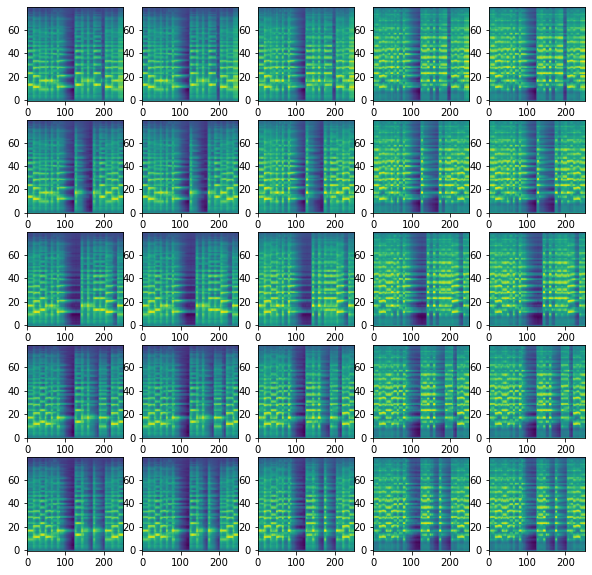

In [137]:
n_int_sample = 5
n_int = 5
idx_piano = np.random.choice(np.where(insts == 0)[0], n_int_sample, replace=False)
idx_organ = np.random.choice(np.where(insts == 1)[0], n_int_sample, replace=False)

vec = []

fig, ax = plt.subplots(n_int_sample, n_int, figsize=(n_int * 2, n_int_sample * 2))
for n, (i, j) in enumerate(zip(idx_piano, idx_organ)):
    mean_p_to_o = outputs['content_mean'][j] - outputs['content_mean'][i]

    if n == 0:
        mean_p_to_o_cat = mean_p_to_o.unsqueeze(0)
    else:
        mean_p_to_o_cat = torch.cat([mean_p_to_o_cat, mean_p_to_o.unsqueeze(0)], dim=0)
    for m, w in enumerate(np.linspace(0, 1, n_int)):
        out = model.decode(
            outputs['posterior'][i].unsqueeze(0), outputs['content_mean'][i].unsqueeze(0) + mean_p_to_o * w
        ).detach().numpy().T
        ax[n][m].imshow(out, aspect='auto', origin='lower')

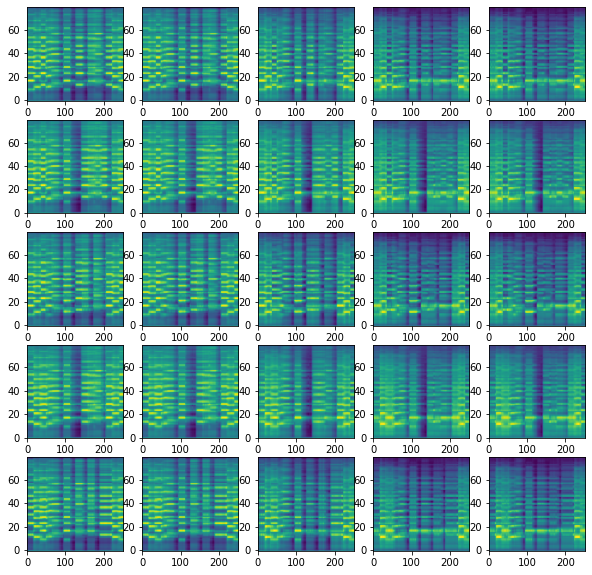

In [138]:
n_int_sample = 5
n_int = 5
idx_piano = np.random.choice(np.where(insts == 0)[0], n_int_sample, replace=False)
idx_organ = np.random.choice(np.where(insts == 1)[0], n_int_sample, replace=False)

fig, ax = plt.subplots(n_int_sample, n_int, figsize=(n_int * 2, n_int_sample * 2))
for n, (i, j) in enumerate(zip(idx_piano, idx_organ)):
    mean_o_to_p = outputs['content_mean'][i] - outputs['content_mean'][j]
    for m, w in enumerate(np.linspace(0, 1, n_int)):
        out = model.decode(
            outputs['posterior'][j].unsqueeze(0), outputs['content_mean'][j].unsqueeze(0) + mean_o_to_p * w
        ).detach().numpy().T
        ax[n][m].imshow(out, aspect='auto', origin='lower')

# Does the local latent encode global information?

In [150]:
from src.loss import masking

In [196]:
for n, batch in enumerate(val_dl):
    print(n)
    input, input_reversed, mask, seq_lengths, labels = batch
    outputs = model.forward(input, input_reversed, seq_lengths, mask)
    mask_posterior, e = masking(outputs['posterior_mean'], mask)
    mask_posterior = mask_posterior.sum(dim=1) / e
    if n == 0:
        posterior_stack = mask_posterior
        labels_stack = labels
    else:
        posterior_stack = torch.vstack([posterior_stack, mask_posterior])
        labels_stack = torch.vstack([labels_stack, labels])

0
1
2
3


In [199]:
posterior_pca = PCA(n_components=2).fit_transform(posterior_stack.detach().numpy())

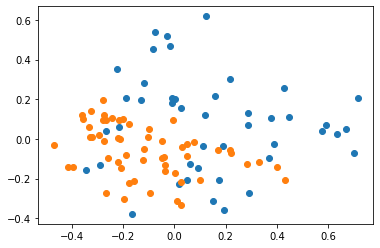

In [200]:
np_labels_stack = labels_stack[:,-1].detach().numpy()
fig, ax = plt.subplots()
for i in np.unique(np_labels_stack):
    x = posterior_pca[np_labels_stack == i]
    ax.scatter(x[:,0], x[:,1], label=str(i))

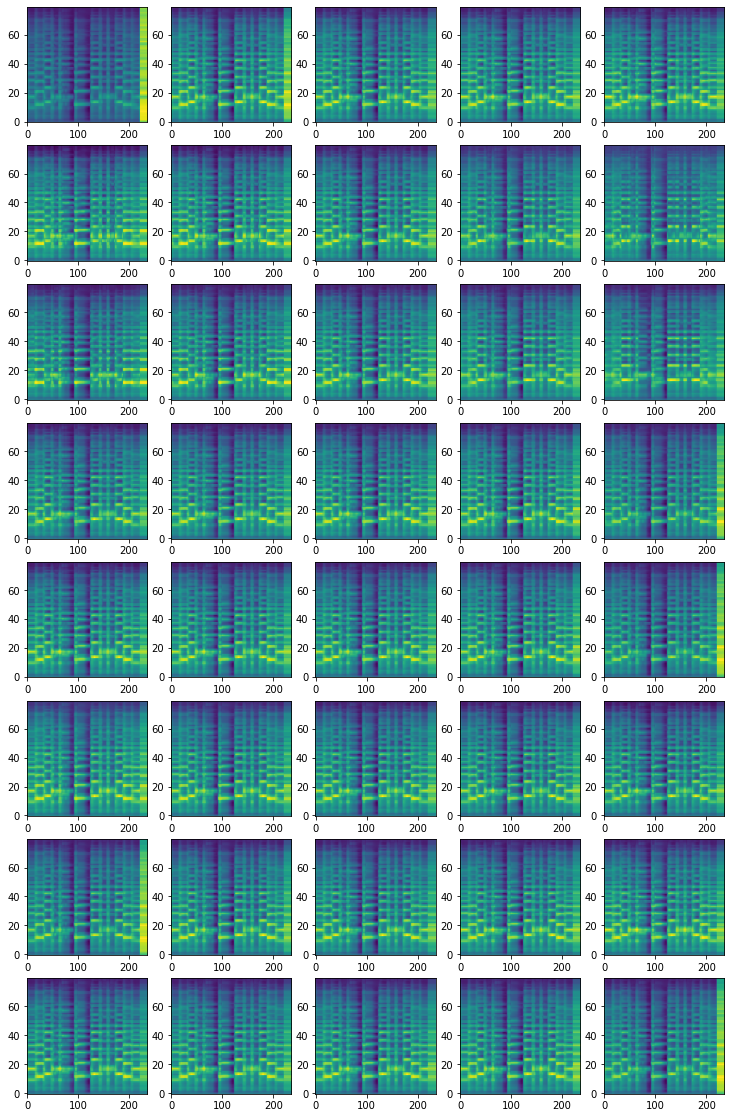

In [205]:
sample_idx = np.random.choice(np.arange(len(outputs['posterior_mean'])), size=1)[0]
origin = model.decode(outputs['posterior_mean'], outputs['content_mean'])[sample_idx].detach().numpy().T

n_traverse = 5
traverse_std_bound = 10
fig, ax = plt.subplots(model.z_dim, n_traverse, figsize=(n_traverse * 2.5, model.z_dim * 2.5))

for z_i in range(model.z_dim):
    std = torch.exp(0.5 * outputs['posterior_logvar'][:, :, z_i])
    std_placeholder = torch.zeros_like(outputs['posterior_logvar'])
    std_placeholder[:, :, z_i] = std
    for j, w in enumerate(np.linspace(-traverse_std_bound, traverse_std_bound, n_traverse)):
        out = model.decode(
            outputs['posterior_mean'] + w * std_placeholder, outputs['content_mean']
        )[sample_idx].detach().numpy().T
        ax[z_i][j].imshow(out, aspect='auto', origin='lower')